# Project 3: Web APIs & Classification
---

# Problem Statement:

There is a need to identify which subreddit a post comes from, in order to target different customer segments as well as selecting appropriate market strategies, for the marketing team of a gaming company, looking into introducing basketball and baseball as sporting games in their latest VR headset offering.

Our chosen model consistently achieved a high score during model evaluation
 
To address the above, we will create a web scrapper to scrape 2 subreddits (r/basketball and r/baseball) and will train 2 separate classification models (CountVectorizer/TfidVectorizer and Logistic Regression), so as to identify which subreddit a post comes from.

The words from each post will undergo a preprocessing stage and EDA will be performed.

Success is evaluated by ensuring that the model has the highest accuracy numbers that are consistent throughout cross validation and train-test-split.

# Executive Summary
---

The global virtual reality headset market size was valued at USD 5.02 billion in 2018 and is expected to register a CAGR of 21.5% over the forecast period, from 2019 to 2025. Virtual reality has gained prominence over the last few years owing to the technological advancements and launch of inventive devices targeted primarily at the gaming industry has an enormous potential to be incorporated into a wide range of applications, including healthcare, education, and industrial prototyping. 

Pay-per-click (PPC), is an internet advertising model used to drive traffic to websites, in which an advertiser pays a publisher (typically a search engine, website owner, or a network of websites) when the ad is clicked.

Through data analytics, we look at targeting personas and audience segmentation to maximize efficiency in terms of out clients'marketing budget


In [2]:
#All libraries used have been added here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import regex as re

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from gensim.models.word2vec import Word2Vec
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('stopwords')


ModuleNotFoundError: No module named 'regex'

In [2]:
pip install -U tensorflow_estimator

Requirement already up-to-date: tensorflow_estimator in /anaconda3/lib/python3.7/site-packages (2.1.0)
Note: you may need to restart the kernel to use updated packages.


In [3]:
basketball = pd.read_csv('./datasets/posts_basketball.csv')
baseball = pd.read_csv('./datasets/posts_baseball.csv')

In [4]:
#creating a duplicate df that can be used later to assess feature columns not in our main df.

basketball_1=basketball.copy()
baseball_1=baseball.copy()

In [5]:
#checking our data
basketball_1.tail(100)
baseball_1.tail(100)

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview,link_flair_template_id,media_metadata,author_cakeday
5324,2158,NaN,baseball,NaN,t2_34692,False,NaN,0,False,Anthony Rizzo talks about the best first base ...,...,1136183.0,1.583183e+09,1.0,{'reddit_video': {'fallback_url': 'https://v.r...,True,hosted:video,{'images': [{'source': {'url': 'https://extern...,fdb62410-f891-11e5-bc76-0ed23bc17a17,NaN,NaN
5325,2159,NaN,baseball,NaN,t2_ghptz,False,NaN,0,False,Would you take Puig?,...,1136183.0,1.583243e+09,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN
5326,2160,NaN,baseball,NaN,t2_75upz,False,NaN,0,False,Kris Bryant and Anthony Rizzo mic'd up during ...,...,1136183.0,1.583208e+09,0.0,{'oembed': {'provider_url': 'https://www.youtu...,False,rich:video,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN
5327,2161,NaN,baseball,"What’s the point for BABIP, in regards to pitc...",t2_5kg82,False,NaN,0,False,Question about BABIP,...,1136183.0,1.583271e+09,0.0,NaN,False,NaN,NaN,f921c92c-f891-11e5-b16f-0ed23bc17a17,NaN,NaN
5328,2162,NaN,baseball,"Hello all, I know someone with T-Mobile and pl...",t2_3pxfv2,False,NaN,0,False,MLB.TV and Watching in Market Games,...,1136183.0,1.583267e+09,0.0,NaN,False,NaN,NaN,f921c92c-f891-11e5-b16f-0ed23bc17a17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5419,2222,NaN,baseball,###What are the expectations for the Rangers t...,t2_8364z,False,NaN,0,False,[Serious] Why will the Texas Rangers exceed ex...,...,1136183.0,1.583169e+09,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN
5420,2223,NaN,baseball,NaN,t2_72hyt,False,NaN,0,False,Mariners' Matt Festa To Undergo Tommy John Sur...,...,1136183.0,1.583176e+09,0.0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN
5421,2224,NaN,baseball,Is OAA more accurate than DRS or UZR?,t2_2racrx9,False,NaN,0,False,Outs Above Average,...,1136183.0,1.583228e+09,0.0,NaN,False,NaN,NaN,NaN,NaN,NaN
5422,2225,NaN,baseball,Our ill-fated traveler is Trevor Wilson of the...,t2_11np6y9e,False,NaN,0,False,"Otis Nixon had 4 HR in his first 789 games, th...",...,1136183.0,1.583170e+09,0.0,NaN,False,NaN,NaN,f778e682-f891-11e5-95a7-0efdf6d303c9,NaN,NaN


In [6]:
#displaying all rows and columns to allow comprehensive search of best features
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# Data Collection
---

Sufficient data was scraped to generate posts from https://www.reddit.com/r/Basketball/ and
https://www.reddit.com/r/Baseball/.

For details on data collection, refer to:<br>
- **'Project 3 Data Collection Basketball.ipynb' (3717 posts)**<br>
- **'Project 3 Data Collection Baseball.ipynb' (5387 posts)**<br>

After the removal of duplicates, the remaining posts are as follows:

- **Basketball (925 posts)**
- **Baseball (931 posts)**

**Before Removal of Duplicates:**

In [7]:
#checking the number of posts before removal of duplicates
print ("Number of posts for Basketball: {} \nNumber of posts for Baseball: {}".format(len(basketball),len(baseball)))

Number of posts for Basketball: 3717 
Number of posts for Baseball: 5424


**After Removal of Duplicates (Basketball & Baseball):**

In [8]:
#checking the number of posts after removal of duplicates

basketball = basketball.drop_duplicates(subset='title', keep='first')
baseball = baseball.drop_duplicates(subset='title', keep='first')

print ("New number of posts for Basketball: {} \nNew number of posts for Baseball: {}".format(len(basketball),len(baseball)))

New number of posts for Basketball: 936 
New number of posts for Baseball: 925


**Removing Unnamed Columns=0**

In [9]:
#removal of unuseful data

basketball.drop(['Unnamed: 0'],axis=1, inplace=True)
baseball.drop(['Unnamed: 0'],axis=1, inplace=True)

**Removing Admin Posts From DataFrame**

In [10]:
#removal of admin posts which are not reflective o =f public commentary
basketball.drop(basketball.index[[0,1]], inplace=True)

**Selection of Relevant Columns (Basketball & Baseball)**<br>
We select only columns which are relevant to our data analysis in terms of using NLP.

In [11]:
basketball=basketball[['subreddit','selftext','title']]
baseball=baseball[['subreddit','selftext','title']]


**Replacing NaN With Blank Spaces**

In [12]:
#we replace NaN with an empty string to facilitate the joining of string columns later.
replace_list_zero=['subreddit','selftext','title']

for i in replace_list_zero: #we create a function that iterates through these columns and filla each NaN with a blank "" string.
    basketball[i].fillna(" ",inplace=True)
    baseball[i].fillna(" ",inplace=True)

**Merging Selftext with Title Columns**

In [13]:
#We join the'selftext' and 'title' of baseballball into one column to facilitate our analysis.
baseball['selftext_title'] =baseball[['selftext', 'title']].apply(' '.join, axis=1)

In [14]:
#We join the'selftext' and 'title' of basketball into one column to facilitate our analysis.
basketball['selftext_title'] =basketball[['selftext', 'title']].apply(' '.join, axis=1)

In [15]:
#We remove the individual 'selftext' and title columns since these have already been duplicated.
basketball=basketball.drop(['selftext','title'], axis=1)
baseball=baseball.drop(['selftext','title'], axis=1)

# Data Cleaning and Preprocessing
---

**Checking of NaNs in Numeric and Non-numeric Columns (Basketball)**

In [16]:
def check_cols(basketball): # we create a function to loop each column, and return the number of NaNs for each datatype.
    check_cols=basketball.select_dtypes([np.object]).columns
    for col in check_cols:
        n_nan=basketball[col].isnull().sum()
        if n_nan>0:
            print ("{} has {} NaNs".format(col,n_nan))
            
    return
pd.DataFrame(check_cols(basketball))

""


**Checking of NaNs in Numeric and Non-numeric Columns (Baseball)**

In [17]:
#we check for NaNs in basketball
basketball.isnull().sum()

subreddit         0
selftext_title    0
dtype: int64

In [18]:
#we check for NaNs in baseball
baseball.isnull().sum()

subreddit         0
selftext_title    0
dtype: int64

**Checking of Data Types**

In [19]:
pd.DataFrame(basketball.dtypes,columns=['data type'])

,data type
subreddit,object
selftext_title,object


In [20]:
pd.DataFrame(baseball.dtypes,columns=['data type'])

,data type
subreddit,object
selftext_title,object


### Concatenating of Basketball and Baseball DataFrames
---

In [21]:
#We concatenate both basketball and baseball colums into one column to facilitate our analysis. 
df=pd.concat([basketball, baseball], axis= 0)

**Resetting of Index**

In [22]:
#We reset the index after merging the 2 columns
df.reset_index(drop=True, inplace=True)

In [23]:
df

,subreddit,selftext_title
0,Basketball,Can anyone tell me why am i a good player when...
1,Basketball,If a player misses a shot because they were ...
2,Basketball,Im wanting to join a team once I go into the 9...
3,Basketball,So i sprained my ankle a month ago but it's st...
4,Basketball,I'm getting into a more active lifestyle and w...
...,...,...
1854,baseball,Now that we know about Madison Bumgarner’s s...
1855,baseball,"Angels #1 prospect, Jo Adell, drives in #2 p..."
1856,baseball,"Hi folks,\n\nAsked this in the Brewers sub, bu..."
1857,baseball,#So what's this thread for?\n\n* Discussion of...


Preprocessing Using Tokenizing, Stop Words and Lemmatization/Stemming
---


#### Tokenizing

In [24]:
tokenizer = RegexpTokenizer(r'\w+') #instantiating the tokenizer

for i in range(len(df['selftext_title'])):#creating a function
    words = df.iloc[i,1]#selecting by integer-location based indexing(where i is looping through each row and 1 refers to the index [1] position of column)
    content_tokens = tokenizer.tokenize(words.lower())#running the tokenizer and replacing with lowercase
    cleaned_string = ' '.join(content_tokens)#joining back the output with a space " " in between
    df.iloc[i,1] = cleaned_string #renaming the output of the function

#### Removing Stop Words

In [25]:

for i in range(len(df['selftext_title'])): #creating a function
    words = df.iloc[i,1] #selecting by integer-location based indexing(where i is looping through each row and 1 refers to the index [1] position of column)
    words = words.split() #splitting the words
    meaningful_words = [w for w in words if not w in stopwords.words('english')]#assigning a variable to collect words which are not found in stop words.
    print(meaningful_words)
    cleaned_string = ' '.join(meaningful_words)#joining back the output with a space " " in between
    df.iloc[i,1] = cleaned_string 


['anyone', 'tell', 'good', 'player', 'playing', '1v1', 'suck', '5v5', 'like', 'dont', 'know', 'im', '1v1', 'vs', '5v5']
['player', 'misses', 'shot', 'fouled', 'still', 'count', 'fga', 'player', 'makes', 'shot', 'despite', 'fouled', 'count', 'fgm', 'fga', 'essentially', 'count', 'fouled', 'fga', 'player', 'makes', 'shot']
['im', 'wanting', 'join', 'team', 'go', '9th', 'grade', 'want', 'know', 'position', 'play', 'im', 'average', 'height', 'age', 'want', 'know', 'position', 'work', 'play', 'tall', '9th', 'grade', 'basketball', 'players']
['sprained', 'ankle', 'month', 'ago', 'still', 'swelling', 'hurts', 'little', 'bit', 'normal', 'recovery', 'long', 'check', 'ankle', 'doctor', 'oh', 'kept', 'playing', 'basketball', 'even', 'though', 'ankle', 'still', 'injured', 'know', 'play', 'love', 'game', 'much', 'stop', 'playing', 'ankle', 'sprain']
['getting', 'active', 'lifestyle', 'better', 'way', 'incorporating', 'sport', 'love', 'unfortunately', 'always', 'pretty', 'casual', 'never', 'practice

['recently', 'searched', 'best', 'basketball', 'thought', 'share', 'early', 'thoughts', 'tested', 'four', 'far', '1', 'spalding', 'nba', 'game', 'ball', '2', 'wilson', 'evolution', '3', 'wilson', 'evo', 'nxt', '4', 'old', 'faithful', '12', 'year', 'old', 'tf', '1000', 'got', 'way', 'including', '5', 'rock', '6', 'maybe', 'spalding', 'precision', 'special', 'testing', 'method', 'scientifically', 'held', 'ball', 'shot', 'gym', 'dribbled', 'around', 'testing', 'conditions', 'aside', 'tf', '1000', 'balls', 'brand', 'new', 'inflated', '8', 'psi', 'recommendations', 'based', 'short', 'term', 'testing', 'know', 'nothing', 'us', 'looking', 'basketball', 'surprise', 'would', 'recommend', 'evolution', 'far', 'common', 'basketball', 'used', 'pickup', 'games', 'many', 'high', 'schools', 'use', 'games', 'easy', 'find', 'sporting', 'goods', 'store', 'see', 'feel', 'ball', 'hands', 'easy', 'see', 'people', 'love', 'soft', 'hands', 'looks', 'nice', 'leather', 'composite', 'maybe', 'expensive', 'lookin

['everytime', 'play', 'basketball', 'always', 'hurt', 'right', 'knee', 'cut', 'anything', 'kind', 'inside', 'pain', 'makes', 'hard', 'walk', 'climb', 'stairs', 'etc', 'usually', 'happens', 'jump', 'layup', 'jumpshot', 'theories', 'repetitive', 'consistent', 'basketball', 'injuries']
['though', 'count', 'nephew', 'still', 'hit', 'layup', 'game']
['realities', 'getting', 'd2', 'scholarship', 'facts', 'd2']
['dream', 'shake', 'took', 'pivot', 'foot', 'one', 'step', 'layup', 'travel', 'pivot', 'take', 'one', 'step', 'lifting', 'pivot', 'foot', 'layup']
['hey', 'guys', 'wondering', 'anyone', 'tips', 'clean', 'restore', 'outdoor', 'basketball', 'ball', 'venice', 'beach', 'rainy', 'city', 'basketballs', 'grip', 'best', 'condition', 'cleaning', 'basketball']
['hey', 'everyone', 'long', 'story', 'short', 'playing', 'men', 'league', 'lost', 'virtually', 'confidence', 'basketball', 'ability', 'practice', 'fine', 'hoop', 'friends', 'fine', 'comes', 'game', 'time', 'effective', 'dribble', 'shot', '

['playing', 'local', 'rec', 'yesterday', 'team', 'got', 'mad', 'fighting', 'screen', 'fast', 'basically', 'man', 'big', 'man', '100lbs', 'everyone', 'closest', 'strength', 'screen', 'set', 'big', 'man', 'starts', 'accelerating', 'got', 'low', 'fast', 'fight', 'stay', 'play', 'screener', 'complained', 'bumped', 'knees', 'hard', 'going', 'fast', 'teammate', 'replied', 'set', 'screen', 'willing', 'take', 'contact', 'take', 'situations', 'like', 'playing', 'hard', 'come', 'undersized', 'dog', 'fight', 'mentality', 'believe', 'smaller', 'man', 'must', 'faster', 'skilled', 'heart', 'hang', 'threw', 'lot', 'thanks', 'fighting', 'screen', 'rough']
['started', 'getting', 'ball', '24', 'playing', 'since', 'highschool', 'painfully', 'discovered', 'herniated', 'disc', 'lower', 'back', 'wondering', 'folks', 'type', 'injury', 'able', 'keep', 'playing', 'ball', 'pretty', 'worried', 'means', 'wont', 'able', 'play', 'anymore', 'especially', 'right', 'rediscovering', 'love', 'game', 'herniated', 'disc',

['basketball', 'want', 'thank', 'ride', 'past', 'years', 'chances', 'compete', 'great', 'individuals', 'memories', 'made', 'brotherhoods', 'forged', 'want', 'thank', 'outlet', 'provided', 'get', 'away', 'anxieties', 'hurts', 'allow', 'positively', 'channel', 'frustrations', 'anger', 'competitive', 'spirit', 'putting', 'path', 'learn', 'winning', 'like', 'loosing', 'like', 'dignity', 'want', 'thank', 'chance', 'find', 'find', 'know', 'purpose', 'without', 'path', 'basketball', 'want', 'thank', 'laughter', 'tears', 'pain', 'pleasure', 'allowed', 'experience', 'want', 'thank', 'last', 'game', 'tonight', 'one', 'last', 'homage', 'every', 'person', 'invested', 'life', 'want', 'remind', 'good', 'times', 'bad', 'give', 'back', 'maybe', 'somebody', 'else', 'thank', 'sincerely', 'thank', 'basketball']
['15', 'going', '11th', 'play', 'street', 'games', 'friend', 'pretty', 'bad', 'wanna', 'play', 'next', 'year', 'play', 'varsity', 'go', 'getting', 'good', 'enough', 'keep', 'snowy', 'rn', 'play', 

['engineering', 'student', 'currently', 'developing', 'smart', 'basket', 'goal', 'system', 'far', 'thinking', 'adding', 'sensors', 'around', 'rim', 'track', 'shots', 'made', 'leds', 'around', 'rim', 'used', 'indicate', 'many', 'things', 'angle', 'shoot', 'also', 'use', 'beacon', 'technology', 'sensors', 'would', 'placed', 'around', 'court', 'system', 'could', 'played', 'alone', 'others', 'used', 'practice', 'want', 'know', 'bought', 'system', 'features', 'would', 'want', 'smart', 'basket', 'system']
['playing', 'basketball', 'pretty', 'frequently', 'recently', 'one', 'player', 'players', 'finding', 'aggresive', 'quite', 'frank', 'people', 'stopped', 'guarding', 'fear', 'getting', 'hurt', 'agreed', 'next', 'game', 'tomorrow', 'gonna', 'start', 'calling', 'fouls', 'since', 'refs', 'want', 'sure', 'though', 'calling', 'things', 'actually', 'rules', 'appreciate', 'help', 'firstly', 'two', 'occasions', 'accidentaly', 'hit', 'someone', 'face', 'first', 'time', 'gaurding', 'back', 'turned', '

['hello', 'basketball', 'season', 'ending', 'noticed', 'alot', 'games', 'played', 'tend', 'pull', 'muscle', 'something', 'leg', 'time', 'knee', 'really', 'interferes', 'alot', 'every', 'game', 'stretch', 'home', '15', 'minutes', 'go', 'game', 'coach', 'makes', 'us', 'stretch', '15', '20', 'minutes', 'know', 'else', 'prevent', 'anything', 'lessen', 'chance', 'every', 'day', 'drink', 'water', 'even', 'practice', 'game', 'days', 'notice', 'people', 'wear', 'like', 'sleeves', 'stuff', 'know', 'helps', 'anything', 'open', 'tips', 'also', 'r', 'basketballtips', 'tips', 'prevent', 'pulling', 'muscle']
['refs', 'players', 'explain', 'calls', 'happened', 'fiba', 'rules', '1', 'first', 'team', 'called', 'sub', 'stoppage', 'team', 'switching', 'team', 'inbounded', 'went', 'take', 'layup', 'one', 'guys', 'grabbed', 'stop', 'getting', 'called', 'foul', 'allowed', 'shoot', 'fts', 'even', 'though', 'one', 'ref', 'blown', 'whistle', 'allow', 'sub', 'ruling', '2', 'called', 'carry', 'without', 'dribbli

['nerdiest', 'comes', 'basketball', 'rules', 'wondering', 'illegal', 'playing', 'basketball', 'week', 'every', 'time', 'kept', 'setting', 'screens', 'push', 'want', 'say', 'something', 'stupid', 'say', 'anything', 'wondering', 'aloud', 'allowed', 'push', 'someone', 'setting', 'screen']
['12', '5', '6', 'taller', 'friend', 'cant', 'hit', 'single', 'one', '1v1', '5', '3', 'irritating', 'shooting', 'pressure']
['athletic', '100m', 'sprinter', 'highjumper', 'prefers', 'jump', 'two', 'feet', '13', 'years', 'old', '5', '9', 'despite', 'height', 'coach', 'always', 'placed', 'centre', 'trouble', 'catching', 'despite', 'long', 'arms', 'big', 'hands', 'possibly', 'due', 'defender', 'close', 'trouble', 'scoring', 'despite', 'double', 'teamed', 'catching', 'high', 'post', 'lacking', 'strength', 'low', 'post', 'quite', 'skinny', 'seeing', 'case', 'mainly', 'score', 'transition', 'rebounds', 'team', 'position', 'allowing', 'iso', 'three', 'point', 'line', 'get', 'layup', 'strengths', 'finishing', 'h

['post', 'might', 'goose', 'egg', 'figured', 'worth', 'asking', 'went', 'shooting', 'today', 'try', 'least', 'every', 'couple', 'days', 'always', 'basketball', 'means', 'throw', 'friends', 'nothing', 'else', 'going', 'basically', 'uhh', 'trash', 'went', '4', '46', 'counted', 'sadly', 'shooting', 'always', 'pretty', 'bad', 'shooter', 'seem', 'getting', 'worse', 'slightly', 'younger', 'would', 'play', 'passing', 'ball', 'around', 'defense', 'issue', '5', '11', '140', 'pounds', 'really', 'anymore', 'get', 'mowed', 'want', 'able', 'pose', 'kind', 'threat', 'court', 'pretty', 'much', 'reign', 'abysmal', 'shooting', 'mostly', 'airballs', 'everyone', 'always', 'told', 'form', 'looks', 'awful', 'shoot', 'like', 'wnba', 'player', 'whatever', 'find', 'feels', 'natural', 'problem', 'shooting', 'general', 'feel', 'natural', 'tried', 'hands', 'swinging', 'hips', 'different', 'ways', 'different', 'foot', 'positions', 'arches', 'etc', 'nothing', 'improved', 'even', 'tiny', 'margin', 'something', 'und

['tl', 'dr', 'bottom', 'always', 'poor', 'jump', 'shot', 'whole', 'life', 'never', 'consistent', 'feeling', 'lot', 'probably', 'poor', 'shooting', 'mechanics', 'really', 'looked', 'deep', 'fixing', 'actually', 'going', 'practicing', 'nowadays', 'sometimes', 'wish', 'could', 'thing', 'well', 'anyways', 'shot', 'around', 'today', 'fun', 'kinda', 'got', 'interested', 'playing', 'never', 'actually', 'played', 'serious', 'pick', 'games', 'actual', 'league', 'games', 'friends', 'basketball', 'fitness', 'high', 'school', 'basketball', 'team', 'jump', 'shot', 'always', 'issue', 'dribbling', 'driving', 'things', 'know', 'could', 'probably', 'consistent', 'practice', 'optimistic', 'shooting', 'yeah', 'consistent', 'feel', 'like', 'chucking', 'ball', 'often', 'getting', 'nice', 'clean', 'shot', 'one', 'shot', 'feels', 'another', 'even', 'go', 'airball', 'lot', 'tried', 'follow', 'end', 'airballing', 'far', 'try', 'adding', 'strength', 'follow', 'glad', 'youtube', 'videos', 'seems', 'gonna', 'put'

['welcome', 'r', 'basketball', 'weekly', 'shoe', 'discussion', 'thread', 'got', 'question', 'need', 'buying', 'advice', 'weekly', 'thread', 'discussing', 'best', 'shoes', 'based', 'type', 'play', 'environment', 'price', 'point', 'etc', 'excited', 'new', 'adidas', 'nike', 'line', 'thread', 'also', 'getting', 'hype', 'next', 'big', 'sneaker', 'moving', 'forward', 'please', 'post', 'individual', 'shoe', 'threads', 'comment', 'organization', 'record', 'keeping', 'r', 'basketball', 'weekly', 'discussion', 'basketball', 'shoes', 'february', '17', '2020']
['5', '5', 'tall', '12']
['new', '14', 'years', 'old', '177sm', '57kg', 'im', 'rly', 'game', 'fell', 'like', 'improving', 'play', 'play', '3v3', 'whit', 'friend', 'im', 'good', 'play', 'whit', 'play', 'real', 'macht', 'school', 'im', 'realy', 'bad', 'nervous', 'tips']
['hi', 'getting', 'basketball', 'interested', 'position', 'use', 'play', 'goalkeeper', 'distribute', 'ball', 'good', 'long', 'range', 'short', 'range', 'pass', 'specialist', 'r

['title', 'says', 'side', 'games', 'typically', 'miss', 'threes', 'midranges', 'make', 'shots', 'almost', 'half', 'court', 'ease', 'however', 'games', 'make', 'threes', 'miss', 'lot', 'midrange', 'shots', 'happening', '12', '7th', 'grade', 'way', 'edit', 'also', 'since', 'practice', 'since', 'play', 'least', '5h', 'day', 'put', 'several', 'hundred', 'midranges', 'threes', 'edit', 'v2', 'also', 'like', 'drill', 'shooting', 'something', 'shoot', 'threes', 'games', 'miss', 'threes', 'outside', 'games']
['heard', 'easily', 'make', '10', 'times', 'wnba', 'salary', 'organization', 'funds', 'leagues', 'genuinely', 'making', 'salaries', 'nba', 'competition', 'overseas', 'anybody', 'details', 'leagues', 'wnba', 'players', 'make', 'overseas']
['kings', 'drafted', 'busts', 'decade', '2006', 'draft', 'could', 'drafted', 'rondo', 'kyle', 'lowry', 'paul', 'millsap', '2007', 'nba', 'draft', 'could', 'drafted', 'marc', 'gasol', '2008', 'nba', 'draft', 'could', 'drafted', 'dragic', 'deandre', 'jordan',

['make', 'least', 'good', 'form', 'rhythm', 'shots', 'defender', 'least', 'front', 'like', 'earlier', 'today', 'pulled', 'three', 'jab', 'step', 'two', 'days', 'ago', 'made', 'one', 'stepback', 'form', 'fluid', 'catch', 'find', 'wide', 'open', 'make', 'wide', 'open', 'shots', 'games']
['uk', 'getting', 'basketball', '2nd', 'year', 'watched', 'follow', 'carolina', 'tar', 'heels', 'someone', 'explain', 'crush', 'teams', 'like', 'nc', 'state', 'hold', 'duke', 'end', 'yet', 'seem', 'get', 'hammered', 'lesser', 'teams', 'simple', 'team', 'inconsistent', 'something', 'college', 'basketball', 'someone', 'help', 'understand']
['title', 'says', 'last', '3', '4', 'months', 'really', 'bad', 'cause', 'form', 'basketball', 'get', 'really', 'bad', 'lower', 'back', 'pain', 'barely', 'move', 'cheers', 'help', 'guys', 'avoid', 'lower', 'back', 'pain', 'basketball', 'games']
['taping', 'wrist', 'past', 'couple', 'games', 'usually', 'comes', 'first', 'quarter', 'redo', 'half', 'time', 'anyone', 'tips', '

['pretty', 'long', 'care', 'go', '3', 'seconds', '3', 'minutes', 'want', 'prove', 'coach', 'takes', 'play', 'game', 'love', '5', '7', 'already', 'knew', 'coming', 'high', 'school', 'freshmen', 'going', 'play', 'except', 'one', 'want', 'improve', 'offense', 'game', 'drive', 'good', 'handles', 'shooting', 'needs', 'work', 'want', 'sound', 'cocky', 'best', 'freshmen', 'defender', 'scrimmages', 'completely', 'shut', 'freshmen', 'almost', 'sophomores', 'get', 'several', 'steals', 'time', 'games', 'mostly', '6', 'sophomores', '1', 'freshmen', 'playing', 'every', 'game', 'noticed', 'unfairness', 'freshmen', 'plays', 'every', 'single', 'game', '7th', 'man', 'bench', 'going', 'sophomore', 'lot', 'better', 'rest', 'us', 'ticked', 'everything', 'better', 'practice', 'make', 'sure', 'guard', 'everytime', 'show', 'coach', 'best', 'freshmen', 'plays', 'games', 'also', 'big', 'attitude', 'problem', 'thinks', 'big', 'allstar', 'want', 'rude', 'still', 'want', 'destroy', 'ego', 'something', 'even', 'wo

['leather', 'wax', 'wondering', 'use', 'bee', 'wax', 'instead', 'know', 'make', 'ball', 'slippery', 'preserve', 'ball', 'stays', 'storage', 'wrapped', 'plastic', 'wrappers', 'ok', 'wax', 'composite', 'basketballs', 'bee', 'wax']
['tips', 'improving', 'jumper', 'know', 'practice', 'makes', 'perfect', 'technique']
['hey', 'play', '3', '2', '1', 'middle', 'school', 'basketball', 'league', 'best', 'game', 'yet', 'scored', '28', 'points', '40', 'ended', 'winning', '40', '35', 'team', 'actually', 'pretty', 'good', 'made', '6', 'threes', 'lots', 'layups', 'game', 'awesome', 'coach', 'proud', 'worried', 'able', 'high', 'school', '8th', 'grade', '5', '4', 'think', 'height', 'really', 'affect', 'think', 'improving', 'high', 'school', 'awesome', 'game']
['love', 'basketball', 'want', 'get', 'better', 'barely', 'turned', '18', 'weigh', '190', 'lbs', '6', '2', 'helps', 'think', 'gotten', 'shooting', 'mostly', 'certain', 'things', 'driving', 'usually', 'make', 'also', 'want', 'improve', 'athleticism

['let', 'call', 'outside', 'school', 'team', 'raptors', 'coach', 'raptors', 'scheduled', 'bunch', 'games', 'saturday', 'sunday', 'high', 'school', 'scheduled', 'tournament', 'team', 'friday', 'saturday', 'well', 'trying', 'figure', 'way', 'go', 'games', 'end', 'one', 'starts', 'even', 'time', 'go', 'gym', 'gym', 'likely', 'different', 'cities', 'also', 'even', 'know', 'parents', 'would', 'able', 'drive', 'much', 'anyways', 'thinking', 'could', 'go', 'schools', 'tournament', 'friday', 'raptors', 'tournament', 'saturday', 'sunday', 'probably', 'going', 'super', 'sore', 'newt', 'days', 'anyone', 'tips', 'avoid', 'happening', 'would', 'helpful', 'play', 'high', 'schools', 'tournament', 'outside', 'schools', 'teams', 'tournament']
['hello', 'fellas', 'studying', 'computer', 'science', 'given', 'assignment', 'think', 'project', 'ideas', 'throughout', 'whole', 'semester', 'project', 'needs', 'consist', 'software', 'hardware', 'parts', 'really', 'like', 'sports', 'would', 'like', 'project', 'r

['currently', 'coaching', 'rec', '3rd', '4th', 'grade', 'girls', 'team', 'trouble', 'getting', 'motivated', 'play', 'example', '3', 'girls', 'play', 'aggressive', 'defense', '5', 'follow', 'handler', 'basket', 'simply', 'stand', 'hands', 'seen', 'shooter', 'key', 'two', 'girl', 'near', 'hands', 'looking', 'side', 'almost', 'like', 'attention', 'elsewhere', 'examples', 'needed', 'key', 'point', 'bad', 'game', 'even', 'trying', 'suggest', 'help', 'motivate', 'get', 'head', 'game', 'getting', '3rd', '4th', 'grade', 'girls', 'game']
['may', 'dumb', 'question', 'okay', 'play', 'basketball', 'day', 'upper', 'body', 'workout', 'experiencing', 'soreness', 'wait', 'couple', 'days', 'play', 'basketball', 'day', 'upper', 'body', 'workout']
['someone', 'give', 'us', 'good', 'analogy', 'personal', 'anecdote', 'try', 'wrap', 'minds', 'around', 'amazing', 'players', 'nba', 'versus', 'average', 'joe', 'even', 'pretty', 'good', 'joe']
['sure', 'right', 'sub', 'oh', 'well', 'playing', 'horse', 'three', 

['hello', 'live', 'michigan', 'right', 'middle', 'winter', 'means', 'play', 'basketball', 'outside', 'like', 'normally', 'obviously', 'anyone', 'know', 'continue', 'working', 'game', 'know', 'places', 'like', 'others', 'really', 'get', 'access', 'like', 'hour', 'drive', 'however', 'still', 'high', 'school', 'means', 'gym', 'school', 'play', 'anxiety', 'goes', 'struggle', 'anxiety', 'care', 'much', 'others', 'think', 'mess', 'even', 'good', 'still', 'feel', 'like', 'something', 'wrong', 'guys', 'think', 'possible', 'dunk', '5', '10', 'junior', 'year', 'freshman', 'currently', 'guys', 'tips', 'working', 'game', 'general', 'one', 'last', 'thing', 'wanted', 'play', 'basketball', 'year', 'decided', 'fear', 'others', 'think', 'said', 'teammates', '7th', '8th', 'grade', 'would', 'actually', 'bully', 'really', 'discouraged', 'playing', 'organized', 'basketball', 'thanks', 'much', 'read', 'end', 'rant', 'appreciate', 'help', 'tips', 'basketball', 'maybe', 'anxiety']
['nba', 'replica', 'basketba

['15', 'male', '5', '9', 'playing', 'basketball', 'year', 'used', 'practise', 'everyday', '5', 'hrs', 'day', 'grinding', 'putting', 'work', 'cold', 'ass', 'british', 'weather', 'took', 'month', 'break', 'nothing', 'happened', 'handles', 'anything', '2nd', 'basketball', 'game', 'score', 'anything', 'get', 'assist', 'got', 'put', 'lost', '4', 'points', 'play', 'games', 'scared', 'anything', 'even', 'though', 'practised', 'thousands', 'times', 'like', 'legs', 'pull', 'back', 'wrapping', 'around', 'simple', 'cross', 'drive', 'past', 'lack', 'confidence', 'aggressive', 'defense', 'comes', 'offense', 'j', 'crumble', 'pass', 'shoot', 'know', 'wrong', 'teammates', 'tell', 'skills', 'coward', 'j', 'know', 'maybe', 'need', 'experience', 'skills', 'confidence', 'even', 'though', 'practise', 'moves', 'thousand', 'times', 'even', 'short', 'people', 'balling', 'better', 'tryout', 'local', 'team', 'get', 'experience', 'better', 'games']
['played', 'ball', 'friends', 'blacktop', 'starting', 'think', '

['hi', 'cut', 'straight', 'point', 'good', 'midrange', 'probably', 'hit', '75', 'percent', 'open', 'shots', 'feel', 'jumpshot', 'mostly', 'fine', 'extend', '3', 'point', 'line', 'shooting', 'form', 'becomes', 'broke', 'feel', 'dont', 'strength', 'shoot', 'even', 'though', 'feel', 'exercises', 'tips', 'increasing', 'shooting', 'range']
['ok', 'got', 'lebron', '17', 'gift', 'aunt', 'lives', 'different', 'country', 'shoe', 'size', 'usually', '11', '5', 'available', 'shoe', 'size', '11', 'amp', '12', 'chose', '11', 'thinking', 'might', 'much', 'difference', 'boy', 'wrong', 'snug', 'love', 'shoe', 'perfect', 'snug', 'get', 'replaced', 'u', 'guys', 'idea', 'loosen', 'toe', 'area', 'coz', 'toes', 'nails', 'started', 'dying', 'big', 'toe', 'keeps', 'hitting', 'toe', 'area', 'loosen', 'toe', 'area', 'basketball', 'shoe']
['recently', 'started', 'playing', 'basketball', 'really', 'struggling', 'controlling', 'dribble', 'anyone', 'tips', 'use', 'help', 'improve', 'dribbling']
['really', 'anybody'

['game', 'winning', 'shot', 'better', '2014', 'game', 'rockets', '2019', 'game', 'winning', 'shot', 'personally', 'think', '2014', 'shot', 'better', 'rush', 'adrenaline', 'head', 'must', 'crazy', 'shooting', 'ball', 'damian', 'lillard', 'game', 'winning', 'shots']
['know', 'much', 'basketball', 'lil', 'bro', 'knee', 'surgery', 'gonna', 'keep', 'unable', 'play', 'sport', 'least', '6', 'months', 'crutches', 'couple', 'teams', 'school', 'made', 'soon', 'unable', 'participate', 'sad', 'situation', 'really', 'wanna', 'something', 'help', 'engage', 'game', 'even', 'though', 'play', 'right', 'hoop', 'home', 'moment', 'use', 'hands', 'throw', 'sitting', 'ideas', 'guys', 'would', 'want', 'done', 'play', 'normally', 'long', 'time', 'thank', 'help', 'basketball', 'loving', 'lil', 'bro']
['team', 'talented', 'therefore', 'forced', 'play', 'lot', 'isolation', 'shoot', 'lot', 'shots', 'order', 'win', 'know', 'right', 'way', 'play', 'ball', 'lol', 'however', 'tonight', 'facing', 'best', 'team', 'leag

['basketball', 'court', 'floors', 'often', 'known', 'sticky', 'grippy', 'sometimes', 'courts', 'closed', 'days', 'apply', 'materials', 'afterwards', 'becomes', 'nice', 'sticky', 'makes', 'shoes', 'squeak', 'like', 'crazy', 'though', 'put', 'floors', 'interestingly', 'though', 'noticed', 'basketball', 'shoes', 'even', 'squeakest', 'models', 'rarely', 'ever', 'squeak', 'right', 'box', 'even', 'compared', 'types', 'athletic', 'shoes', 'even', 'stickest', 'courts', 'appears', 'put', 'protective', 'layer', 'wax', 'new', 'shoe', 'makes', 'screeching', 'noise', 'layer', 'rubs', 'playing', 'repeated', 'games', 'put', 'basketball', 'court', 'floor', 'makes', 'sticky', 'grippy']
['amp', 'x200b', 'n', 'club', 'sport', 'trophies', 'country', '1', 'al', 'ahly', 'football', '118', 'egypt', '2', 'rangers', 'football', '115', 'scotland', '3', 'barcelona', 'handball', '114', 'spain', '4', 'nacional', 'football', '113', 'uruguay', '5', 'penerol', 'football', '108', 'uruguay', '6', 'wigan', 'warriors', '

['sophomore', 'high', 'school', 'chosen', 'basketball', 'team', 'even', 'though', 'one', 'best', 'guards', 'freshman', 'year', 'new', 'coach', 'know', 'anything', 'basketball', 'real', 'skill', 'know', 'freshman', 'team', 'tryouts', 'told', 'us', 'play', 'match', 'even', 'though', 'one', 'best', 'players', 'guard', '6', '5', 'shooting', 'guard', 'got', 'scholarship', 'play', 'college', 'basketball', 'scored', 'lot', 'points', 'rebounding', 'scored', 'threes', 'match', 'thought', 'definitely', 'team', 'every', 'name', 'coach', 'said', 'chances', 'getting', 'slimmer', 'slimmer', 'finally', 'finished', 'say', 'name', 'told', 'coach', 'think', 'forgot', 'name', 'said', 'said', 'everyone', 'name', 'team', 'disbelief', 'friend', 'never', 'basketball', 'team', 'would', 'always', 'beat', '21', '0', 'got', 'chosen', 'many', 'freshmen', 'played', 'trash', 'still', 'got', 'chosen', '3', 'friends', 'mine', 'complained', 'coach', 'coach', 'said', 'stop', 'moaning', 'throw', 'team', 'feel', 'like', 

['pretty', 'bad', 'shot', 'know', 'sometime', 'shooting', 'free', 'throws', 'underhanded', 'recommended', 'understand', 'shooting', '3', 'underhanded', 'could', 'lead', 'easy', 'blocked', 'shots', 'want', 'enough', 'threat', 'defender', 'leave', 'wide', 'open', 'anyone', 'shot', 'underhanded', '3', 'effectively', 'underhand', '3', 'pointer']
['right', 'handed', 'legs', 'left', 'leg', 'fine', 'try', 'going', 'right', 'feels', 'super', 'weird', 'work', 'legs']
['atlanta', 'hawks', 'forward', 'chandler', 'parsons', 'playing', 'days', 'may', 'following', 'car', 'wreck', 'attorneys', 'say']
['pick', 'ball', 'go', 'shot', 'creating', 'separation', 'dribble', 'always', 'goes', 'palm', 'never', 'finger', 'tips', 'shoot', 'short', 'feels', 'uncomfortable', 'catch', 'shoot', 'finger', 'tips', 'comfortable', 'nice', 'wrist', 'flick', 'splash', 'time', 'way', 'work', 'ending', 'habit', 'putting', 'ball', 'finger', 'tips', 'shooting', 'thanks', 'shooting', 'release', 'picking', 'dribble']
['hear', 

['basketball', 'dictionary', 'dylan', 'murphy', 'great', 'resource', 'struggling', 'play', 'concepts']
['third', 'year', 'son', 'played', 'basketball', 'ok', 'basketball', 'past', 'year', 'showing', 'real', 'talent', 'perhaps', 'best', 'kid', 'entire', 'league', 'virtually', 'outside', 'practice', 'basketball', 'hoop', 'home', 'access', 'one', 'nearby', 'far', 'tell', 'ever', 'play', 'school', 'prodigy', 'anything', 'shown', 'aptitude', 'like', 'encourage', 'especially', 'since', 'tall', 'two', 'questions', 'hoping', 'help', 'since', 'know', 'anything', 'basketball', 'first', 'good', 'youtube', 'videos', 'watch', 'basketball', 'fundamentals', 'developmentally', 'appropriate', '5th', 'grader', 'books', 'resources', 'found', 'videos', 'seem', 'targeted', 'much', 'older', 'players', 'second', 'competitive', 'always', 'wanting', 'better', 'asked', 'keep', 'track', 'steals', 'rebounds', 'shots', 'paint', 'every', 'game', 'looks', 'stats', 'last', 'game', 'tries', 'outdo', 'previous', 'recor

['2000', 'nba', 'draft', 'jordan', 'crawford', '2001', 'nba', 'draft', 'pau', 'gasol', '2002', 'nba', 'draft', 'yao', 'ming', '2003', 'nba', 'draft', 'lebron', 'james', '2004', 'nba', 'draft', 'dwight', 'howard', '2005', 'nba', 'draft', 'chris', 'paul', '2006', 'nba', 'draft', 'lamarcus', 'aldridge', '2007', 'nba', 'draft', 'kevin', 'durant', '2008', 'nba', 'draft', 'derrick', 'rose', '2009', 'nba', 'draft', 'steph', 'curry', '2010', 'nba', 'draft', 'paul', 'george', '2011', 'nba', 'draft', 'kawhi', 'leonard', '2012', 'nba', 'draft', 'anthony', 'davis', '2013', 'nba', 'draft', 'giannis', 'antehokoopto', '2014', 'nba', 'draft', 'nikola', 'jokic', '2015', 'nba', 'draft', 'karl', 'anthony', 'town', '2016', 'nba', 'draft', 'pascal', 'siakam', '2017', '2018', '2019', 'early', 'best', 'nba', 'player', 'nba', 'draft', 'since', '2000']
['hey', 'guys', 'recently', 'gotten', 'basketball', 'live', 'uk', 'considering', 'getting', 'league', 'pass', 'seen', 'lot', 'people', 'complaining', 'pros', 'c

['english', 'mother', 'tounge', 'really', 'sorry', 'bad', 'english', 'start', 'play', 'basketball', 'year', 'playing', 'friend', 'fun', 'without', 'proper', 'training', 'fundamental', 'live', 'pretty', 'small', 'city', 'basketball', 'popular', 'cannot', 'find', 'coach', 'academy', 'train', 'want', 'improve', 'basketball', 'skills', 'fundamental', 'full', 'workout', '2', 'hours', 'per', 'day', 'plan', 'ok', 'anything', 'need', 'adjust', 'often', 'workout', 'combine', 'three', '1', 'day', 'separate', 'dribbling', '1', '1', 'hand', 'dribble', '100', 'reps', 'hand', '2', 'crossover', '100', 'reps', '3', 'leg', '100', 'reps', '4', 'change', 'pace', 'layup', '1', 'overhand', 'layup', 'basket', '10', 'made', 'left', 'amp', 'right', '2', '1', 'dribble', 'layup', '10', 'made', 'left', 'amp', 'right', '3', 'fingeroll', 'layup', '10', 'made', 'left', 'amp', 'right', '4', 'eurostep', 'layup', '10', 'made', 'left', 'amp', 'right', 'shooting', '1', 'right', 'corner', 'amp', 'wing', 'top', 'key', 'le

['workout', 'schedule', 'schedule', 'lift', '3rd', 'period', 'monday', 'wednesday', 'friday', 'ballhandling', '5pm', 'get', 'home', '5', '30', 'workout', '6', 'usually', 'shooting', 'workout', 'monday', 'finishing', 'workout', 'wednesday', 'combo', 'workout', 'friday', 'isolation', 'moves', 'shuffle', 'depending', 'time', 'since', 'control', 'schedule', 'tuesday', 'thursday', 'pickup', 'basketball', 'morning', 'core', 'basketball', 'workouts', 'longer', 'also', 'days', 'missing', 'workouts', 'like', 'something', 'came', 'one', 'day', 'workout', 'lot', 'times', 'end', 'working', 'longer', 'supposed', 'fear', 'might', 'get', 'workout', 'would', 'workout', 'school', 'since', 'stay', 'late', 'problem', 'gyms', 'either', 'closed', 'occupied', 'whatever', 'team', 'practicing', 'weight', 'room', 'usually', 'open', 'chances', 'already', 'lifted', 'bring', 'ball', 'school', 'provided', 'basketballs', '3rd', 'period', 'want', 'get', 'lost', 'stolen', 'whole', 'world', 'gonna', 'ask', 'ball', 'al

['low', 'self', 'esteem', 'self', 'confidence', 'issue', 'never', 'try', 'middle', 'school', 'finally', 'gathered', 'enough', 'courage', 'try', 'year', 'unfortunately', 'knee', 'injury', 'surgery', 'set', 'back', 'gotten', 'shape', 'plan', 'working', 'summer', 'never', 'played', 'school', 'team', 'would', 'really', 'like', 'love', 'basketball', 'passionate', 'game', 'edit', 'eighth', 'grade', 'freshmen', 'like', '8', 'months', 'chance', 'make', 'high', 'school', 'team']
['hey', 'player', 'mostly', 'plays', 'rec', 'leagues', 'due', 'huge', '6a', 'school', 'missing', 'tryouts', 'year', 'honestly', 'good', 'back', 'improved', 'lot', 'fine', 'bettering', 'lot', 'fun', 'even', 'senior', 'year', 'high', 'school', 'love', 'basketball', 'irrelevant', 'real', 'problem', 'live', 'one', 'rainiest', 'cities', 'us', 'portland', 'almost', 'days', 'outside', 'wet', 'access', 'gyms', 'area', 'addition', 'live', 'apartment', 'dribble', 'inside', 'without', 'getting', 'immediate', 'response', 'neighbor'

['short', 'player', 'running', 'around', 'freethrow', 'line', 'gathers', 'ball', 'basically', 'puts', 'two', 'hands', 'ball', 'holds', 'head', 'driving', 'defender', 'lane', 'basically', 'slap', 'ball', 'touch', 'ball', 'thinking', 'going', 'shoot', 'release', 'short', 'offensive', 'player', 'running', 'short', 'guy', 'never', 'releases', 'ball', 'defender', 'slaps', 'slap', 'block', 'attempt', 'ball', 'releases', 'hands', 'ball', 'head', 'level', 'drops', 'chest', 'level', 'attempts', 'shot', 'layup', 'typically', 'takes', '5', '6', 'steps', 'going', 'amp', 'x200b', 'inclination', 'travel', 'possibly', 'jump', 'ball', 'sometimes', 'defenders', 'get', 'hand', 'top', 'ball', 'although', 'possession', 'piece', 'ball', 'temporarily', 'although', 'ball', 'still', 'hands', 'offender', 'player', 'however', 'entirely', 'sure', 'legal', 'move', 'refs', 'care', 'chime', 'amp', 'x200b', 'justifies', 'claiming', 'travel', 'players', 'got', 'hand', 'ball', '3rd', 'step', 'men', 'league', 'ref', '5

['hi', 'title', 'states', 'tonight', 'new', 'amateur', 'b', 'ball', 'club', 'play', 'first', 'organized', 'game', 'refs', 'everything', 'good', '8', 'years', 'mostly', 'played', 'pickup', 'anyone', 'general', 'tips', 'big', 'differences', 'two', 'assuming', 'reffing', 'stress', 'pace', 'play', 'might', 'different', 'men', '3rd', 'division', 'league', 'europe', 'btw', 'thanks', 'first', 'organized', 'game', 'long', 'time', 'tips']
['cant', 'seem', 'face', 'basket', 'entirely', 'turn', 'around', 'way', 'square', 'basket', 'efficiently', 'improve', 'post', 'fadeaways']
['good', 'handles', 'able', 'get', 'rim', 'dunk', 'alot', 'secret', 'able', 'get', 'game', 'dunks']
['hi', 'get', 'plenty', 'questions', 'semi', 'naive', 'people', 'asking', 'make', 'pro', 'player', 'figured', 'change', 'bit', 'ask', 'naive', 'question', 'make', 'coach', 'little', 'bit', '19', 'years', 'old', 'living', 'uk', 'pretty', 'good', 'player', 'school', 'sit', 'bench', 'university', 'roughly', 'translates', 'even',

['12', 'years', 'old', '5', '8', '1', '73', '94', 'pounds', 'ca', '43', 'kg', 'cant', 'make', 'free', 'throws', 'consistently', 'make', 'jump', 'shots', 'im', 'pretty', 'weak', 'center', 'struggle', 'paint', 'make', 'layups', 'hooks', 'also', 'defend', 'improve', 'game', 'get', 'ready', 'make', 'team', 'next', 'year']
['hi', 'live', 'tokyo', 'wondering', 'anybody', 'would', 'willing', 'play', 'basketball', 'summer', 'preferably', 'someone', 'better', 'willing', 'help', 'get', 'better', 'place', 'would', 'play', 'court', 'front', 'minatoku', 'sports', 'center', 'https', 'www', 'minatoku', 'sports', 'com', 'https', 'www', 'minatoku', 'sports', 'com', 'court', 'inside', 'always', 'open', 'usually', 'go', 'inside', 'theres', 'also', 'gym', 'inside', 'entry', 'fee', '800', 'believe', 'go', 'tuesdays', 'thursdays', 'saturdays', 'sundays', 'club', 'activity', 'days', 'please', 'dm', 'comment', 'intrested', 'discord', 'plus', 'sorry', 'english', 'bad', 'lol', 'summer', 'basketball']
['hi', 'lo

['making', 'thread', 'many', 'people', 'seem', 'idea', 'difficult', 'get', 'nba', 'regardless', 'starting', 'nba', 'best', 'best', 'best', 'basketball', 'absolute', 'greatest', 'planet', '4', '500', 'spots', 'tens', 'millions', 'time', 'think', 'read', 'somewhere', 'difficult', 'merit', 'based', 'organization', 'get', 'earth', 'regardless', 'true', 'astronomically', 'hard', 'get', 'league', 'stop', 'trying', 'dream', 'go', 'keep', 'working', 'towards', 'long', 'feel', 'feasible', 'kind', 'seems', 'many', 'know', 'good', 'nba', 'player', 'setting', 'disappointment', 'minds', 'right', 'place', 'getting', 'college', 'play', 'ball', 'hard', 'recognize', 'nba', 'player', 'like', '10', 'times', 'better', 'best', 'player', 'college', 'basketball', 'keep', 'mind', 'try', 'improve', 'years', 'want', 'happen', 'take', 'everything', 'excuses', 'must', 'dominate', 'competition', 'early', 'possible', 'must', 'stand', 'early', 'possible', 'takes', 'dedication', 'desire', 'give', 'luck', 'halfass', '

['good', 'amount', 'posts', 'recently', 'get', 'recruited', 'people', 'want', 'play', 'd1', 'basketball', 'posts', 'people', 'outside', 'united', 'states', 'touch', 'individually', 'later', 'order', 'get', 'recruited', 'get', 'scholarship', 'ncaa', 'd1', 'school', 'really', 'mean', 'really', 'good', 'basketball', 'mean', 'really', 'good', 'people', 'clue', 'good', 'actually', 'use', 'example', 'played', 'prep', 'school', 'basketball', 'played', 'good', 'aau', 'team', 'grinded', 'thousands', 'hours', 'formula', 'walk', 'gym', '95', 'time', 'best', 'player', 'end', 'walked', 'd3', 'facts', '1', 'high', 'school', 'players', 'go', 'play', 'd1', 'average', 'height', 'd1', 'basketball', 'player', '6', '3', '6', '5', 'depending', 'source', 'use', 'looking', 'numbers', 'hard', 'd1', 'basketball', 'player', 'short', 'becomes', 'even', 'harder', 'way', 'get', 'recruited', 'great', 'potential', 'high', 'ceiling', 'exclusive', 'people', 'extremely', 'tall', 'athletic', 'combination', 'two', 'kids'

['hey', 'guys', 'got', 'kneed', 'side', 'quad', 'yesterday', 'trying', 'work', 'screen', 'quick', 'fix', 'creams', 'solutions', 'help', 'reduce', 'pain', 'playing', 'tonight', 'remedies', 'injury']
['34', 'played', 'basketball', 'virtually', 'everyday', 'age', '12', '18', 'used', 'watch', 'basketball', 'videos', 'play', 'park', 'local', 'school', 'loved', 'considered', 'self', 'pretty', 'good', 'literally', 'touched', 'ball', '16', 'year', 'want', 'start', 'playing', 'get', 'back', 'shape', 'problem', 'literally', 'none', 'friends', 'play', 'interested', 'thinking', 'hiring', 'court', 'local', 'gym', 'practice', 'self', 'rent', 'hour', 'anybody', 'started', 'hooping', 'loooong', 'time', 'anybody', 'picked', 'rock', 'loooooong', 'time', 'played', 'ball', '16', 'years']
['deal', 'slippery', 'courts', 'indoor', 'outdoor', 'ones']
['welcome', 'r', 'basketball', 'weekly', 'shoe', 'discussion', 'thread', 'got', 'question', 'need', 'buying', 'advice', 'weekly', 'thread', 'discussing', 'best',

['hi', '15', 'year', 'old', 'wanting', 'improve', 'game', 'shoot', 'around', 'alot', 'compete', '5', 'times', 'week', 'however', 'vertical', 'lateral', 'quickness', 'week', 'want', 'bouncy', 'like', 'jalen', 'green', 'wondering', 'could', 'give', 'personalized', 'program', 'also', 'know', 'im', 'overtraining', 'leg', 'workout', 'end', 'vertical', 'jumps', 'suddenly', 'felt', 'knee', 'hurting', 'alot', 'vertical', 'decreased', 'bit', 'overtraining', 'thank', 'need', 'get', 'better', 'suggestions', 'personalized', 'program', 'questions', 'overtraining']
['trying', 'find', 'toronto', 'raptors', 'vince', 'carter', '98', '99', 'hwc', 'swingman', 'jersey', 'either', 'white', 'purple', 'preferably', 'white', 'men', 'medium', 'find', 'one', 'anywhere', 'either', 'size', 'arent', 'selling', 'stumbled', 'upon', 'site', 'throwback', 'since', 'want', 'get', 'scammed', 'skeptical', 'authenticity', 'jersey', 'anyone', 'know', 'site', 'trusted', 'cant', 'please', 'link', 'one', 'trustworthy', 'throwb

['think', 'checked', 'correctly', 'take', 'anything', 'away', 'nats', 'nats', 'fans', 'seen', 'word', 'finished', 'year', 'original', 'pennant', 'thought', 'take', 'look', 'last', 'update', 'google', 'doc', 'phillies', 'beat', 'mets', 'sept', '9', '2019', 'phillies', 'sept', '9th', 'sept', '15', 'losing', 'red', 'sox', 'red', 'sox', 'sept', '15', 'sept', '19', 'losing', 'giants', 'giants', 'sept', '19', 'sept', '22', 'losing', 'braves', 'braves', 'sept', '22', 'sept', '29', 'ended', 'season', 'getting', 'swept', 'mets', 'leaving', 'mets', 'holder', 'original', 'pennant', 'end', 'year', 'decade', 'never', 'heard', 'check', 'details', 'https', 'www', 'reddit', 'com', 'r', 'baseball', 'comments', 'bgvwvv', 'original_pennant_update_tonight_the_nationals_and', 'utm_source', 'share', 'amp', 'utm_medium', 'ios_app', 'amp', 'utm_name', 'iossmf', 'celebrate', 'mets', 'fans', 'mets', 'finish', 'decade', 'original', 'pennant']
['good', 'examples', 'players', 'perfect', 'batting', 'stance', 'almos

['rosters', 'coaching', 'staffs', 'announced', 'pool', '1', 'world', 'baseball', 'classic', 'qualifier']
['guess', 'baseball', 'signed', 'almost', 'entire', '1965', 'dodgers', 'team', 'including', 'sandy', 'koufax']
['drellich', 'video', 'editing', 'disciplinary', 'precedents', 'debated', 'mlb', 'sign', 'stealing', 'talks']
['angels', 'fire', 'employee', 'allegedly', 'furnishing', 'illegal', 'substances', 'put', 'baseballs']
['rosenthal', '3b', 'yoan', 'moncada', 'agreement', 'whitesox', 'five', 'year', 'extension', 'club', 'option', 'sources', 'tell', 'athletic', 'dollars', 'yet', 'known', 'would', 'potentially', 'buy', 'two', 'free', 'agent', 'years', 'option', 'exercised', 'moncada', 'would', 'hit', 'open', 'market', 'age', '30', 'season']
['planning', 'getting', 'baseball', 'upcoming', 'season', 'gonna', 'try', 'watch', 'spring', 'training', 'games', 'tomorrow', 'get', 'idea', 'games', 'like', 'obviously', 'asking', 'every', 'individual', 'rule', 'general', 'explanation', 'sport', 

['line', 'score', 'final', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'r', 'h', 'e', 'stl', 'stl', '0', '3', '0', '0', '3', '1', '4', '0', '0', '11', '14', '0', 'wsh', 'wsh', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '6', '0', 'box', 'score', 'wsh', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'stl', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'ss', 'turner', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '607208', '3', '0', '0', '0', '0', '1', '235', '2b', 'edman', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '669242', '5', '1', '2', '3', '0', '0', '286', 'spacer', 'rf', 'spacer', 'williamson', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '607776', '1', '0', '0', '0', '0', '1', '067', 'cf', 'carlson', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '666185', '4', '1', '2', '0', '1', '0', '417', 'rf', 'stevenson', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '664057', '2', '0', '1', '0', '0'

['thinking', 'amazing', 'bill', 'dickey', 'era', 'transitioned', 'berra', 'era', 'transitions', 'elston', 'howard', 'ear', 'turned', 'thurmon', 'munson', 'era', 'even', 'season', 'without', '3', 'jake', 'gibbs', 'frank', 'fernndez', 'platoon', 'held', 'sandwiched', 'absolute', 'titans', 'catching', 'absolutely', 'staggering', 'production', 'single', 'position', '5', 'decades', 'doubt', 'significant', 'reason', 'team', '18', 'championships', '47', 'years', 'season', 'primary', 'catcher', 'team', 'catcher', 'war', 'world', 'series', 'win', '1933', 'bill', 'dickey', '4', '7', '1934', 'bill', 'dickey', '3', '1', '1935', 'bill', 'dickey', '2', '6', '1936', 'bill', 'dickey', '5', '6', '1937', 'bill', 'dickey', '6', '9', '1938', 'bill', 'dickey', '5', '6', '1939', 'bill', 'dickey', '5', '7', '1940', 'bill', 'dickey', '2', '8', '1941', 'bill', 'dickey', '4', '5', '1942', 'bill', 'dickey', '2', '4', '1943', 'bill', 'dickey', '5', '1944', 'mike', 'garbark', '1', '6', '1945', 'mike', 'garbark', '

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'cardinals', '5', '7', 'nationals', '4', '6', 'first', 'pitch', '6', '05', 'pm', 'fitteam', 'ballpark', 'palm', 'beaches', 'pitcher', 'tv', 'radio', 'cardinals', 'r', 'cardinals', 'carlos', 'martinez', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '593372', '0', '0', '4', '15', 'era', 'kmox', 'nationals', 'r', 'nationals', 'tba', 'masn', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '606574', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '03', '05', 'amp', 'team', 'nationals', 'amp', 'dh', '1', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '03', 'amp', 'day', '05', 'amp', 'year', '2020', 'amp', 'game', 'gid_2020_03_05_slnmlb_wasmlb_2', '2f', 'live', 'comments', 'http', 'reddit', 'stream', '

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'yankees', '8', '3', 'tigers', '5', '5', 'first', 'pitch', '1', '05', 'pm', 'publix', 'field', 'joker', 'marchant', 'stadium', 'pitcher', 'tv', 'radio', 'yankees', 'r', 'nyyankees', 'gerrit', 'cole', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '543037', '0', '0', '0', '00', 'era', 'tigers', 'r', 'motorcitykitties', 'casey', 'mize', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '663554', '0', '0', '9', '00', 'era', 'fsd', 'wxyt', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '604640', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '03', '05', 'amp', 'team', 'tigers', 'amp', 'dh', '0', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '03', 'amp', 'day', '05', 'amp', 'year',

['going', 'investigate', 'much', 'astros', 'benefited', 'cheating', 'statistically', 'significant', 'benefit', 'players', 'benefited', 'look', 'tony', 'adams', 'data', 'http', 'signstealingscandal', 'com', 'http', 'signstealingscandal', 'com', 'posted', 'reddit', 'earlier', 'adams', 'data', 'bangs', '8000', 'pitches', 'along', 'pitch', 'data', 'result', 'per', 'pitch', 'look', 'swinging', 'strikes', 'breaking', 'balls', 'theory', 'know', 'breaking', 'ball', 'coming', 'swing', 'miss', 'lower', 'rate', 'swing', 'miss', 'rate', 'change', 'bang', 'data', 'astros', 'batters', 'swung', 'missed', '272', '1809', 'breaking', 'balls', 'bangs', 'swung', 'missed', '58', '702', 'breaking', 'balls', 'bangs', 'amp', 'x200b', 'https', 'preview', 'redd', 'joqmouxa1pk41', 'png', 'width', '193', 'amp', 'format', 'png', 'amp', 'auto', 'webp', 'amp', '2e66607290c25fecb1ca6d89b59986913c3ec1c6', 'swinging', 'strike', 'rate', '15', 'without', 'bangs', '8', 'bangs', 'put', 'context', '2017', 'astros', 'led', '

['hello', 'r', 'baseball', 'wondering', 'guys', 'would', 'interested', 'mlb', 'imperialism', 'series', 'season', 'people', 'done', 'r', 'nfl', 'r', 'cfb', 'r', 'collegebasketball', 'way', 'works', 'mlb', 'team', 'starts', 'plot', 'land', 'nearest', 'home', 'stadium', 'team', 'gets', 'defeated', 'land', 'gets', 'taken', 'team', 'beat', 'goes', 'like', 'either', 'season', 'land', 'owned', 'one', 'team', 'concept', 'see', 'u', 'jloose', 'u', 'meberathezebra', 'u', 'nbingham196', 'really', 'good', 'job', 'mlb', 'thinking', 'would', 'base', 'series', 'series', 'basis', 'land', 'ends', 'one', 'team', 'fast', 'maybe', 'start', 'star', 'break', 'trying', 'make', 'land', 'stay', 'teams', 'longer', 'consider', 'allowing', 'road', 'teams', 'take', 'land', 'reply', 'think', 'would', 'work', 'subreddit', 'open', 'suggestions', 'thanks', 'canada', 'map', 'https', 'imgur', 'com', 'xglgrxt', 'usa', 'map', 'https', 'imgur', 'com', 'gj9wobf', 'thoughts', 'imperialism', 'series', 'mlb']
['line', 'score',

['16', 'arizona', 'diamondbacks', '90', '72', '15', 'philadelphia', 'phillies', '86', '76', '14', 'chicago', 'cubs', 'cubs', '2019', 'missed', 'playoffs', 'first', 'time', 'since', '2014', 'even', 'though', 'good', 'team', 'guys', 'like', 'kris', 'bryant', 'https', 'www', 'fangraphs', 'com', 'players', 'kris', 'bryant', '15429', 'stats', 'position', '3b', 'anthony', 'rizzo', 'https', 'www', 'fangraphs', 'com', 'players', 'anthony', 'rizzo', '3473', 'stats', 'position', '1b', 'rebounding', 'going', 'bit', '2018', 'cubs', 'chance', 'compete', 'season', 'nl', 'central', 'tossup', '4', 'teams', 'cubs', 'still', 'many', 'pieces', 'world', 'series', 'winning', 'team', '2016', 'like', 'bryant', 'rizzo', 'kyle', 'hendricks', 'https', 'www', 'fangraphs', 'com', 'players', 'kyle', 'hendricks', '12049', 'stats', 'position', 'p', 'superstar', 'javier', 'baez', 'https', 'www', 'fangraphs', 'com', 'players', 'javier', 'baez', '12979', 'stats', 'position', '2b', 'ss', '2019', 'record', '84', '78', 't

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'giants', '6', '5', 'dodgers', '6', '4', 'first', 'pitch', '8', '05', 'pm', 'camelback', 'ranch', 'pitcher', 'tv', 'radio', 'giants', 'r', 'sfgiants', 'johnny', 'cueto', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '456501', '0', '0', '0', '00', 'era', 'mlb', 'com', 'dodgers', 'r', 'dodgers', 'clayton', 'kershaw', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '477132', '0', '0', '0', '00', 'era', 'snla', '570', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '605026', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '03', '05', 'amp', 'team', 'dodgers', 'amp', 'dh', '0', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '03', 'amp', 'day', '05', 'amp', 'year', '2020', 'amp', 'g

['favorite', 'ballpark', 'design', 'cincinnati', 'palace', 'fans', '1902', '1911', 'day', 'surprised', 'one', 'tried', 'copy', 'design']
['cards', 'andrew', 'miller', 'loses', 'feeling', 'pitches']
['dallas', 'keuchel', 'spends', '25', '000', 'team', 'dinner', 'preps', 'new', 'start', 'white', 'sox', 'mired', '11', 'year', 'playoff', 'drought']
['billshaikin', 'grilled', 'cheese', 'sandwich', 'top', 'cheeseburger', 'top', 'another', 'grilled', 'cheese', 'sandwich', 'greetings', 'goodyear', 'arizona', 'america']
['brien', 'braves', 'félix', 'hernández', '2', '08', 'era', '3', 'spring', 'starts', 'allowed', '7', 'hits', '2', 'runs', '3', 'walks', '8', 'strikeouts', '8', '2', '3', 'innings']
['thread', 'discussion', 'yesterday', 'games', 'excitement', 'today', 'games', 'general', 'questions', 'mildly', 'interesting', 'facts', 'praising', 'santa', 'anything', 'else', 'worth', 'sharing', 'asking', 'warrant', 'post', 'game', 'threads', 'use', 'games', 'schedule', 'sidebar', 'navigate', 'team

['expectations', 'phillies', 'year', 'exceed', 'expectations', 'asking', 'question', 'every', 'team', 'next', 'month', 'going', 'bottom', 'standings', 'top', 'finishing', 'time', 'opening', 'day', 'tomorrow', 'team', 'chicago', 'cubs', '_______________', 'previous', 'teams', 'series', 'march', '2nd', 'texas', 'rangers', 'https', 'www', 'reddit', 'com', 'r', 'baseball', 'comments', 'fcf5qz', 'serious_why_will_the_texas_rangers_exceed', 'march', '1st', 'san', 'francisco', 'giants', 'https', 'www', 'reddit', 'com', 'r', 'baseball', 'comments', 'fbx58m', 'serious_why_will_the_san_francisco_giants_exceed', 'february', '29th', 'cincinnati', 'reds', 'https', 'www', 'reddit', 'com', 'r', 'baseball', 'comments', 'fbggnu', 'serious_why_will_the_cincinnati_reds_exceed', 'february', '28th', 'chicago', 'white', 'sox', 'https', 'www', 'reddit', 'com', 'r', 'baseball', 'comments', 'faxwx6', 'serious_why_will_the_chicago_white_sox_exceed', 'february', '27th', 'los', 'angeles', 'angels', 'https', 'www'

['would', 'take', 'puig']
['kris', 'bryant', 'anthony', 'rizzo', 'mic', 'spring', 'training', 'game']
['point', 'babip', 'regards', 'pitchers', 'seems', 'kind', 'anti', 'fip', 'mostly', 'measures', 'fielding', 'behind', 'pitcher', 'meant', 'give', 'us', 'way', 'try', 'take', 'fielding', 'account', 'question', 'babip']
['hello', 'know', 'someone', 'mobile', 'plan', 'using', 'subscription', 'mlb', 'tv', 'know', 'market', 'games', 'blacked', 'go', 'making', 'seem', 'like', 'area', 'know', 'buy', 'install', 'something', 'impact', 'anything', 'respect', 'using', 'universities', 'website', 'applications', 'etc', 'since', 'area', 'anymore', 'sorry', 'dumb', 'questions', 'idea', 'want', 'waste', 'time', 'money', 'realistically', 'thanks', 'mlb', 'tv', 'watching', 'market', 'games']
['pablo', 'sandoval', 'takes', 'home', 'wild', 'pitch', 'bounces', '2', 'feet', 'plate']
['nyc', 'area', 'may', 'remember', 'ansky', 'series', 'adidas', 'tv', 'commercials', 'series', 'nike', 'tv', 'commercials', 'a

['watching', 'lot', 'spring', 'training', 'games', 'upside', 'downside', 'implementing', 'electronic', 'strike', 'zone', 'hot', 'topic', 'personally', 'high', 'school', 'baseball', 'player', 'feel', 'feel', 'fundamentally', 'changes', 'important', 'parts', 'game', 'curiosity', 'guys', 'think', 'potential', 'technology', 'guys', 'think', 'impact', 'game', 'electronic', 'strike', 'zones']
['bottom', '9th', 'tie', 'game', 'two', 'men', 'put', 'base', 'pitcher', 'replaced', 'new', 'pitcher', 'inherits', 'runners', 'new', 'pitcher', 'lets', '3', 'run', 'bomb', 'take', 'loss', 'homerun', 'first', 'pitcher', 'take', 'loss', 'first', 'runner', 'cross', 'plate', 'alright', 'stats', 'boys', 'question']
['hi', 'fan', 'sport', 'never', 'really', 'thought', 'trying', 'kinda', 'wanted', 'change', 'know', 'worth', '18', 'also', 'tall', '5', '1', 'mostly', 'holding', 'back', 'late', 'start', 'learning', 'play']
['front', 'team', 'official', 'jerseys', 'feature', 'text', 'logo', 'number', 'player', 'ne

['30', 'detroit', 'tigers', '49', '113', '29', 'baltimore', 'orioles', '57', '105', '28', 'seattle', 'mariners', '60', '102', '27', 'san', 'francisco', 'giants', '54', '108', '26', 'kansas', 'city', 'royals', '64', '98', '25', 'miami', 'marlins', '64', '98', '24', 'pittsburgh', 'pirates', '64', '98', '23', 'colorado', 'rockies', '64', '98', '22', 'texas', 'rangers', '73', '81', '21', 'toronto', 'blue', 'jays', '77', '85', '20', 'san', 'diego', 'padres', '86', '76', '19', 'chicago', 'white', 'sox', '85', '77', '18', 'los', 'angeles', 'angels', '80', '82', '17', 'milwaukee', 'brewers', '79', '83', '16', 'arizona', 'diamondbacks', '90', '72', '15', 'philadelphia', 'phillies', 'already', 'know', 'putting', 'phillies', '15', 'may', 'end', 'well', 'phillies', 'definitely', 'good', 'team', 'know', 'best', 'player', 'bryce', 'harper', 'https', 'www', 'fangraphs', 'com', 'players', 'bryce', 'harper', '11579', 'stats', 'position', 'signed', '330m', 'mega', 'deal', 'last', 'offseason', 'yes', 'pl

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'cubs', '5', '5', 'athletics', '6', '6', 'first', 'pitch', '9', '05', 'pm', 'hohokam', 'stadium', 'pitcher', 'tv', 'radio', 'cubs', 'r', 'chicubs', 'alec', 'mills', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '621219', '1', '0', '0', '00', 'era', 'athletics', 'r', 'oaklandathletics', 'frankie', 'montas', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '593423', '1', '0', '0', '00', 'era', 'nbcsca', 'cast', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '605606', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '03', '03', 'amp', 'team', 'athletics', 'amp', 'dh', '1', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '03', 'amp', 'day', '03', 'amp', 'year', '2020', 'amp', 'game'

['amp', 'x200b', 'https', 'preview', 'redd', 'psceljzcx9k41', 'png', 'width', '414', 'amp', 'format', 'png', 'amp', 'auto', 'webp', 'amp', '30b53e60dabd8219493789c29d5f19d784ee3a58', 'two', 'players', 'listed', 'team', 'refers', 'platoon', 'players', 'platoon', 'one', 'position', 'starters', 'refer', 'end', 'year', 'roster', 'players', 'highlighted', 'white', 'opening', 'day', 'roster', 'roster', 'movement', 'player', 'plays', 'games', 'position', 'may', 'necessarily', 'listed', 'starter', 'correct', 'year', 'listed', 'first', 'comment', 'starting', 'first', 'baseman', 'guess', 'year']
['realized', 'mlb', 'logo', 'could', 'viewed', 'either', 'right', 'handed', 'left', 'handed', 'batter', 'picture', 'demonstrate']
['expectations', 'rangers', 'year', 'exceed', 'expectations', 'asking', 'question', 'every', 'team', 'next', 'month', 'going', 'bottom', 'standings', 'top', 'finishing', 'time', 'opening', 'day', 'tomorrow', 'team', 'philadelphia', 'phillies', '_______________', 'previous', 't

['line', 'score', 'final', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'r', 'h', 'e', 'min', 'min', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '4', '2', 'stl', 'stl', '1', '3', '0', '0', '0', '0', '2', '0', '6', '12', '0', 'box', 'score', 'stl', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'min', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', '2b', 'edman', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '669242', '5', '2', '2', '1', '0', '1', '227', '2b', 'arraez', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '650333', '2', '0', '0', '0', '1', '0', '125', 'spacer', '2b', 'spacer', 'robertson', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '670298', '0', '0', '0', '0', '0', '0', '000', 'spacer', '3b', 'spacer', 'reinheimer', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '595373', '1', '0', '0', '0', '0', '1', '000', 'c', 'molina', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '425877', '3', '1', '

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'twins', '4', '3', 'cardinals', '3', '6', 'first', 'pitch', '1', '05', 'pm', 'roger', 'dean', 'chevrolet', 'stadium', 'pitcher', 'tv', 'radio', 'twins', 'r', 'minnesotatwins', 'devin', 'smeltzer', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '656970', '1', '0', '6', '23', 'era', 'cardinals', 'r', 'cardinals', 'kwang', 'hyun', 'kim', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '547942', '0', '0', '0', '00', 'era', 'fsmw', 'crn', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '606185', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '03', '02', 'amp', 'team', 'cardinals', 'amp', 'dh', '0', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '03', 'amp', 'day', '02', 'amp', 'yea

['dave', 'stewart', 'threw', 'one', 'blue', 'jays', 'fernando', 'valenzuela', 'tossed', 'another', 'dodgers', 'cardinals', '1990', 'also', 'year', 'broke', 'record', 'hitters', 'thrown', 'season', '7', 'total', 'beating', 'previous', 'record', '6', '1908', 'til', 'two', 'hitters', 'thrown', 'day', 'june', '29', '1990']
['going', 'dansby', 'swanson', 'feel', 'like', 'gotten', 'lot', 'criticism', 'things', 'really', 'great', 'defender', 'think', 'agree', 'time', 'though', 'hitting', 'nearly', 'bad', 'everyone', 'makes', 'lot', 'ss', 'position', 'general', 'lot', 'great', 'hitters', '2014', 'median', 'ss', 'average', '260', 'jose', 'reyes', 'leading', 'baseball', '287', '2017', 'median', 'ss', 'average', '265', 'jean', 'segura', 'leading', 'majors', '300', 'last', 'year', 'median', 'ss', 'average', '283', 'tim', 'anderson', 'leading', 'bigs', 'astounding', '335', 'swansons', 'average', 'slowly', 'crept', 'every', 'year', 'hes', 'atlanta', 'arguing', 'good', 'hitter', 'mediocre', 'stats', 

['line', 'score', 'final', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'r', 'h', 'e', 'atl', 'atl', '0', '0', '0', '0', '0', '0', '0', '0', '2', '2', '4', '0', 'bos', 'bos', '2', '1', '0', '0', '0', '0', '0', '1', '4', '6', '0', 'box', 'score', 'bos', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'atl', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'dh', 'chavis', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '656308', '0', '1', '0', '0', '1', '0', '222', 'rf', 'acuña', 'jr', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '660670', '3', '0', '0', '0', '0', '1', '125', 'spacer', 'dh', 'spacer', 'mieses', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '644407', '1', '0', '1', '0', '2', '0', '500', 'spacer', 'rf', 'spacer', 'jenista', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '680571', '0', '1', '0', '0', '1', '0', '222', '3b', 'devers', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '646240', '3', '1', '

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'braves', '3', '5', 'red', 'sox', '3', '5', 'first', 'pitch', '1', '05', 'pm', 'jetblue', 'park', 'pitcher', 'tv', 'radio', 'braves', 'r', 'braves', 'mike', 'foltynewicz', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '592314', '0', '0', '4', '50', 'era', '680', 'red', 'sox', 'r', 'redsox', 'nathan', 'eovaldi', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '543135', '0', '0', '0', '00', 'era', 'nesn', 'weei', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '604059', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '03', '01', 'amp', 'team', 'red', 'sox', 'amp', 'dh', '0', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '03', 'amp', 'day', '01', 'amp', 'year', '2020', 'amp', 'g

['espn', 'wanted', 'chemo', 'fernando', 'tatis', 'jr', 'sign', 'bald', 'head', 'got', 'wish']
['city', 'frederick', 'asking', 'help', 'keeping', 'minor', 'league', 'baseball', 'team']
['putting', 'tommy', 'john', 'surgery', '7', 'years', 'regardless', 'picked', '2', 'sticks', 'today', 'reconditioned', 'glove', 'might', 'well', 'get', 'hours', 'cages', 'preparation', 'mens', 'league', 'next', 'year']
['browne', 'one', 'interesting', 'thing', 'come', 'morning', 'chaim', 'bloom', 'basically', 'going', 'give', 'ron', 'roenicke', 'coaching', 'staff', 'primer', 'opener', 'tomorrow', 'wonder', 'power', 'point', 'presentation']
['boland', 'boone', 'said', 'judge', 'undergone', 'additional', 'testing', 'including', 'mri', 'come', 'back', 'negative', 'another', 'test', 'monday', 'felt', 'discomfort', 'hitting', 'inside', 'yesterday', 'timeline', 'moment', 'anything', 'figure', 'issue']
['verducci', 'baseball', 'fight', 'reclaim', 'soul']
['posnanski', 'baseball', '100', '27', 'mike', 'trout']
['

['stark', 'charlie', 'montoyo', 'biggio', 'playing', 'cf', 'second', 'baseman', 'lucky', 'play', 'different', 'spots', 'going', 'play', 'one', 'day', 'montoyo', 'also', 'said', 'chance', 'joe', 'panik', 'makes', 'team', 'playing', 'well', 'biggio', 'could', 'play', 'cf']
['wanted', 'post', 'fyi', 'anyone', 'subscribed', 'mlbtv', 'last', 'year', 'planning', 'continuing', 'service', 'according', 'website', 'subscribed', 'mlbtv', 'last', 'year', 'subscription', 'set', 'renew', 'march', '1st', 'however', 'already', 'began', 'processing', 'payments', 'case', 'feb', '27th', 'never', 'got', 'email', 'subscription', 'renewed', 'became', 'aware', 'checking', 'bank', 'statement', 'warning', 'planning', 'renewing', 'yout', 'mlbtv', 'subscription', 'might', 'already', 'charged', 'another', 'year']
['first', 'attempt', 'score', 'game', 'watched', '2004', 'alcs', 'game', '1', 'baseball', 'fan', 'series', 'great', 'game', 'sure', 'made', 'tons', 'mistakes', 'fun']
['week', 'lsu', 'softball', 'maribet

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'nationals', '2', '4', 'cardinals', '2', '5', 'first', 'pitch', '1', '05', 'pm', 'roger', 'dean', 'chevrolet', 'stadium', 'pitcher', 'tv', 'radio', 'nationals', 'r', 'nationals', 'patrick', 'corbin', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '571578', '0', '0', 'era', '106', '7', 'cardinals', 'r', 'cardinals', 'carlos', 'martinez', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '593372', '0', '0', '13', '50', 'era', 'fsmw', 'kmox', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '606184', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '02', '29', 'amp', 'team', 'cardinals', 'amp', 'dh', '0', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '02', 'amp', 'day', '29', 'amp', 

['puma', 'nimmo', 'back', 'camp', 'says', 'underwent', 'ekg', 'ensure', 'heart', 'walls', 'thickened', 'irregular', 'heartbeat', 'says', 'fine', 'little', 'bit', 'larger', 'heart', 'lot', 'love', 'give', 'nimmo', 'said']
['tv', 'radio', 'cheating', 'scandal', 'puts', 'astros', 'broadcasters', 'tough', 'spot']
['bobby', 'nightengale', 'trevor', 'bauer', 'wants', 'pitch', 'every', '4', 'days', 'instead', '5']
['top', 'prospects', 'eligible', 'play', 'respective', 'countries', 'summer', 'games']
['sounds', 'like', 'ugly', 'speier', 'https', 'twitter', 'com', 'alexspeier', 'status', '1233486595195576320', 'witnessed', '1', '4', '3', '6', 'triple', 'play', 'soft', 'liner', 'back', 'twins', 'pitcher', 'caught', 'hit', 'ground', 'threw', '2b', 'evidently', 'pulled', 'bag', '2b', 'threw', '1b', 'get', 'jeter', 'downs', 'got', 'caught', 'halfway', '2nd', '1b', 'threw', 'back', 'ss', 'sure', 'video', 'twins', 'made', 'triple', 'play', 'vs', 'red', 'sox', 'today']
['rochester', 'democrat', 'chron

['line', 'score', 'final', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'r', 'h', 'e', 'col', 'col', '0', '0', '0', '5', '0', '0', '1', '0', '0', '6', '7', '2', 'sf', 'sf', '1', '0', '0', '4', '1', '3', '0', '0', '9', '11', '0', 'box', 'score', 'sf', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'col', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'ss', 'crawford', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '543063', '3', '0', '0', '0', '0', '1', '286', 'lf', 'tapia', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '606132', '3', '0', '0', '0', '0', '3', '364', 'spacer', 'ss', 'spacer', 'howard', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '664031', '2', '0', '0', '0', '0', '1', '364', 'spacer', 'cf', 'spacer', 'boswell', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '641385', '2', '0', '0', '0', '0', '2', '583', 'c', 'bart', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '663698', '2', '2', '1', '0', 

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'rockies', '3', '2', 'giants', '4', '2', 'first', 'pitch', '9', '05', 'pm', 'scottsdale', 'stadium', 'pitcher', 'tv', 'radio', 'rockies', 'r', 'coloradorockies', 'antonio', 'senzatela', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '622608', '0', '0', 'era', 'koa', 'giants', 'r', 'sfgiants', 'johnny', 'cueto', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '456501', '0', '0', 'era', 'nbcsba', 'knbr', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '605991', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '02', '29', 'amp', 'team', 'giants', 'amp', 'dh', '1', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '02', 'amp', 'day', '29', 'amp', 'year', '2020', 'amp', 'game', 'gid_202

['personal', 'opinion', 'buehler', 'better', 'flaherty', 'mlb', 'network', 'seems', 'believe', 'flaherty', 'shoe', 'cy', 'young', 'award', 'winner', 'ahead', 'degrom', 'honestly', 'better', 'edit', 'discrediting', 'flaherty', 'know', 'great', 'pitcher', 'point', 'mlb', 'network', 'seems', 'thing', 'competition', 'walker', 'buehler', 'overshadowed', 'jack', 'flaherty']
['mccann', 'mlb', 'defend', 'sign', 'stealing', 'lawsuits', 'daily', 'fantasy', 'players']
['seen', 'updated', 'rosters', 'snes', 'griffey', 'titles', 'well', 'made', 'mvp', '05', 'yet', 'see', 'n64', 'classic', 'anyone', 'know', 'already', 'exist', 'someone', 'working', 'little', 'tech', 'skill', 'could', 'lend', 'hand', 'helping', 'give', 'ratings', 'players', 'always', 'big', 'fan', 'simple', '1', '10', 'system', 'updated', 'roster', 'mods', 'mlb', 'ft', 'ken', 'griffey', 'jr', 'n64']
['jomboy', 'orioles', 'blaring', 'fake', 'crowd', 'noise', 'practice', 'calling', 'pop', 'ups']
['picked', 'garage', 'sale', 'idea', 'pl

['light', 'astros', 'recent', 'sign', 'stealing', 'cheating', 'scandal', 'attempts', 'revitalize', 'claim', 'astros', 'pitchers', 'using', 'illegal', 'substance', 'la', 'pine', 'tar', 'increase', 'spin', 'rate', 'claim', 'first', 'made', 'public', 'trevor', 'bauer', 'two', 'years', 'ago', 'really', 'blow', 'full', 'scandal', 'various', 'reasons', 'https', 'www', 'usatoday', 'com', 'story', 'sports', 'mlb', '2018', '05', '02', 'trevor', 'bauer', 'astros', 'spin', 'rate', 'cheating', '572199002', 'https', 'www', 'usatoday', 'com', 'story', 'sports', 'mlb', '2018', '05', '02', 'trevor', 'bauer', 'astros', 'spin', 'rate', 'cheating', '572199002', 'one', 'main', 'reason', 'really', 'evidence', 'aside', 'hearsay', 'mean', 'sure', 'bauer', 'experiment', 'might', 'proved', 'using', 'illegal', 'substance', 'could', 'improve', 'spin', 'rate', 'hardly', 'surprising', 'considering', 'know', 'spitballs', 'history', 'pitchers', 'doctoring', 'balls', 'different', 'creative', 'ways', 'proving', 'guns'

['line', 'score', 'final', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'r', 'h', 'e', 'hou', 'hou', '2', '0', '0', '0', '0', '0', '0', '3', '0', '5', '6', '0', 'wsh', 'wsh', '1', '0', '1', '0', '2', '1', '0', '0', '0', '5', '10', '1', 'box', 'score', 'wsh', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'hou', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'rf', 'eaton', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '594809', '2', '3', '2', '1', '1', '0', '667', 'dh', 'springer', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '543807', '3', '0', '0', '0', '0', '2', '167', 'spacer', 'ss', 'spacer', 'garcia', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '671277', '2', '0', '2', '0', '0', '0', '444', 'spacer', 'dh', 'spacer', 'tucker', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '663656', '2', '0', '0', '0', '0', '0', '000', '3b', 'cabrera', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '452678', '2', '0',

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'astros', '2', '3', 'nationals', '2', '3', 'first', 'pitch', '6', '05', 'pm', 'fitteam', 'ballpark', 'palm', 'beaches', 'pitcher', 'tv', 'radio', 'astros', 'r', 'astros', 'cristian', 'javier', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '664299', '0', '0', 'era', 'atth', 'kbme', 'nationals', 'r', 'nationals', 'max', 'scherzer', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '453286', '0', '0', 'era', '106', '7', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '606570', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '02', '27', 'amp', 'team', 'nationals', 'amp', 'dh', '0', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '02', 'amp', 'day', '27', 'amp', 'year', '2020', 'amp',

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'rays', '2', '2', 'yankees', '2', '2', 'first', 'pitch', '1', '05', 'pm', 'george', 'steinbrenner', 'field', 'pitcher', 'tv', 'radio', 'rays', 'r', 'tampabayrays', 'aaron', 'slegers', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '642083', '0', '0', '0', '00', 'era', 'fs', 'sun', 'yankees', 'r', 'nyyankees', 'j', 'happ', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '457918', '0', '0', '0', '00', 'era', 'yes', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '605506', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '02', '27', 'amp', 'team', 'yankees', 'amp', 'dh', '1', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '02', 'amp', 'day', '27', 'amp', 'year', '2020', 'amp', 'gam

['funny', 'houston', 'astros', 'win', '2020', 'world', 'series', 'america', 'popular', 'baseball', 'writers', 'weigh']
['espn', 'cousin', 'autism', 'remember', 'score', 'every', 'yankees', 'game', 'since', '2014']
['max', 'scherzer', 'like', 'mlb', 'rule', 'changes', 'suggestions', 'fix']
['hey', 'people', 'analysis', 'juiced', 'ball', '2019', 'trained', 'neural', 'network', 'data', '2015', '2018', 'predict', 'outcome', 'plays', '2019', 'thoughts', 'would', 'appreciated']
['hey', 'r', 'baseball', 'working', 'project', 'final', 'semester', 'college', 'rather', 'fun', 'one', 'tracking', 'success', 'major', 'league', 'sports', 'teams', 'decade', 'analyzing', 'well', 'correlates', 'movement', 'population', 'economic', 'activity', 'within', 'us', 'past', '60', 'years', 'basically', 'trying', 'find', 'way', 'boil', 'many', 'teams', 'stats', 'possible', 'one', 'ratio', 'determine', 'teams', 'success', 'given', 'year', 'observe', 'changes', 'relation', 'socio', 'economic', 'state', 'teams', 's

['line', 'score', 'final', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'r', 'h', 'e', 'tb', 'tb', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '7', '0', 'nyy', 'nyy', '3', '0', '0', '2', '0', '0', '0', '2', '7', '9', '0', 'box', 'score', 'nyy', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'tb', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'cf', 'gardner', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '458731', '2', '0', '1', '1', '1', '1', '250', 'rf', 'margot', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '622534', '3', '0', '0', '0', '0', '0', '250', 'spacer', 'cf', 'spacer', 'milone', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '641882', '2', '0', '0', '0', '0', '0', '143', 'spacer', 'rf', 'spacer', 'lukes', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '664770', '1', '0', '0', '0', '0', '0', '000', '1b', 'voit', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '572228', '2', '1', '0', '0', '1

['nearing', 'beginning', 'season', 'seeing', 'lots', 'posts', 'comments', 'asking', 'help', 'picking', 'team', 'help', 'give', 'guidance', 'lost', 'souls', 'allow', 'us', 'give', 'good', 'resource', 'downvoting', 'removing', 'post', 'continuing', 'annual', 'tradition', 'putting', 'together', 'guide', 'helping', 'people', 'pick', 'team', 'second', 'team', 'year', 'edition', 'one', 'funny', 'flow', 'charts', 'astros', 'fans', 'fact', 'souls', 'hey', 'yankees', 'fans', 'great', 'different', 'team', 'butt', 'joke', 'hope', 'actually', 'help', 'people', 'find', 'teams', 'want', 'follow', 'throughout', 'year', 'performance', 'based', 'questions', 'based', 'last', 'couple', 'years', 'well', 'projections', 'hate', 'hard', 'step', 'one', 'make', 'list', 'following', 'abbreviations', 'ari', 'atl', 'bal', 'bos', 'chc', 'chw', 'cin', 'cle', 'col', 'det', 'hou', 'kcr', 'laa', 'lad', 'mia', 'mil', 'min', 'nym', 'nyy', 'oak', 'phi', 'pit', 'sdp', 'sea', 'sfg', 'stl', 'tbr', 'tex', 'tor', 'wsn', 'step

['30', 'detroit', 'tigers', '49', '113', '29', 'baltimore', 'orioles', '57', '105', '28', 'seattle', 'mariners', '60', '102', '27', 'san', 'francisco', 'giants', '54', '108', '26', 'kansas', 'city', 'royals', '64', '98', '25', 'miami', 'marlins', '64', '98', '24', 'pittsburgh', 'pirates', '64', '98', '23', 'colorado', 'rockies', '63', '99', '22', 'texas', 'rangers', '73', '81', '21', 'toronto', 'blue', 'jays', '77', '85', '20', 'san', 'diego', 'padres', '86', '76', '19', 'chicago', 'white', 'sox', '85', '77', '18', 'los', 'angeles', 'angels', '80', '82', '17', 'milwaukee', 'brewers', 'brewers', '2019', 'snuck', 'playoffs', 'superstar', 'player', 'christian', 'yelich', 'https', 'www', 'fangraphs', 'com', 'players', 'christian', 'yelich', '11477', 'stats', 'position', 'got', 'injured', 'september', '10th', 'brewers', 'game', 'wild', 'card', 'seemed', 'lost', 'playoff', 'hopes', 'opposite', 'happened', 'end', 'season', 'well', 'going', '13', '5', 'getting', 'past', 'cubs', 'wild', 'card',

['line', 'score', 'final', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'r', 'h', 'e', 'atl', 'atl', '0', '1', '1', '0', '0', '1', '0', '0', '0', '3', '8', '0', 'bal', 'bal', '2', '0', '0', '0', '2', '0', '0', '0', '4', '9', '1', 'box', 'score', 'bal', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'atl', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', '3b', 'alberto', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '593643', '3', '1', '2', '0', '0', '0', '333', 'rf', 'acuña', 'jr', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '660670', '3', '0', '0', '0', '0', '2', '200', 'spacer', '3b', 'spacer', 'bannon', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '676625', '1', '0', '0', '0', '0', '0', '375', 'spacer', 'rf', 'spacer', 'robinson', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '453203', '1', '0', '0', '0', '0', '0', '167', 'lf', 'smith', 'jr', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '596105', '3',

['join', 'us', 'discord', 'https', 'discordapp', 'com', 'invite', 'kqs2kzg', 'braves', '1', '2', 'orioles', '1', '4', 'first', 'pitch', '1', '05', 'pm', 'ed', 'smith', 'stadium', 'pitcher', 'tv', 'radio', 'braves', 'r', 'braves', 'sean', 'newcomb', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '656794', '0', '0', 'era', 'wifn', 'orioles', 'r', 'orioles', 'asher', 'wojciechowski', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '592879', '0', '0', 'era', 'masn', 'mlb', 'fangraphs', 'brooks', 'baseball', 'reddit', 'stream', 'irc', 'chat', 'gameday', 'https', 'www', 'mlb', 'com', 'gameday', '603960', 'game', 'graph', 'http', 'www', 'fangraphs', 'com', 'livewins', 'aspx', 'date', '2020', '02', '26', 'amp', 'team', 'orioles', 'amp', 'dh', '0', 'amp', 'season', '2020', 'strikezone', 'map', 'http', 'www', 'brooksbaseball', 'net', 'pfxvb', 'zonetrack', 'php', 'month', '02', 'amp', 'day', '26', 'amp', 'year', '2020', 'amp', 'game', 'gid_2020_02_26_atlmlb_

['day', 'u', 'iamubik', 'published', 'impressive', 'insightful', 'analysis', 'https', 'www', 'reddit', 'com', 'r', 'baseball', 'comments', 'exkkoz', 'i_went_through_the_footage_provided_by_uatadams', 'finalizing', 'preliminary', 'data', 'exploration', 'findings', 'astros', 'use', 'trash', 'banging', 'hitters', 'interpreted', 'signal', 'acted', 'upon', 'additional', 'information', 'accordingly', 'inspired', 'abovementioned', 'post', 'figured', 'similarly', 'share', 'findings', 'post', 'statistics', 'findings', 'opinions', 'based', 'effect', 'banging', 'trash', 'cans', 'take', 'account', 'whistling', 'buzzing', 'whatnot', 'data', 'yet', 'analysis', 'done', 'notion', 'analyzing', 'batter', 'performance', 'given', 'pitches', 'preceded', 'trash', 'banging', 'whatever', 'beating', 'would', 'interesting', 'draw', 'conclusions', 'based', 'lack', 'trash', 'bang', 'acting', 'signal', 'e', 'bang', 'indicate', 'speed', 'pitch', 'bang', 'indicates', 'fastball', 'absence', 'speed', 'pitch', 'however

['line', 'score', 'final', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'r', 'h', 'e', 'mia', 'mia', '0', '2', '0', '0', '1', '0', '1', '0', '3', '7', '12', '0', 'hou', 'hou', '0', '0', '0', '0', '0', '4', '0', '0', '0', '4', '4', '0', 'box', 'score', 'hou', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'mia', 'ab', 'r', 'h', 'rbi', 'bb', 'ba', 'rf', 'tucker', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '663656', '2', '0', '0', '0', '0', '0', '000', 'ss', 'berti', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '542932', '3', '1', '2', '0', '0', '0', '286', 'spacer', 'rf', 'spacer', 'meyers', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '676694', '1', '1', '0', '0', '0', '0', '000', 'spacer', 'ss', 'spacer', 'chisholm', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '665862', '0', '1', '0', '0', '2', '0', '1', '000', '2b', 'díaz', 'http', 'mlb', 'mlb', 'com', 'team', 'player', 'jsp', 'player_id', '649557', '1', '0

['starting', 'play', 'around', 'baseball', 'data', 'looking', 'cool', 'pulls', 'work', 'help', 'improve', 'thought', 'interesting', 'see', '2017', 'astros', 'performed', 'kershaw', 'speed', 'stuff', 'vs', 'rest', 'teams', 'faced', 'season', 'game', '5', 'ws', 'vs', 'hou', 'clearly', 'best', 'team', 'fared', 'kershaws', 'speed', 'stuff', 'far', 'season', 'average', 'swing', 'miss', 'rate', 'kershaw', 'speed', 'pitches', '2', 'vs', '19', 'data', 'showed', 'houston', 'swung', 'missed', '1', 'time', '51', 'sl', 'cu', 'ch', 'kershaw', 'threw', 'jose', 'altuve', 'striking', '1st', 'inning', 'slider', 'trash', 'man', 'probably', 'pooping', 'interestingly', 'enough', 'teams', 'pretty', 'low', 'rates', 'year', 'often', 'nl', 'west', 'teams', 'would', 'bit', 'sensible', 'due', 'higher', 'exposure', 'kershaw', 'stuff', 'given', 'kershaw', 'success', 'game', '1', 'suspect', 'astros', 'decided', 'increase', 'aggression', 'cheating', 'point', 'pretty', 'early', 'game', '5', 'though', 'sure', 'probab

['batter', 'perspective', '761', 'total', 'pitches', 'outside', 'zone', 'called', 'strikes', 'team', 'came', 'considerably', 'close', 'number', 'san', 'diego', 'padres', '746', 'pitches', 'outside', 'zone', 'called', 'strikes', 'reference', 'top', '5', 'teams', 'terms', 'pitches', 'outside', 'strikezone', 'called', 'strikes', 'batter', 'perspective', 'team', 'num', '1', 'nationals', '761', '3', '1', '2', 'padres', '746', '3', '2', '3', 'yankees', '732', '2', '9', '4', 'reds', '725', '3', '2', '5', 'blue', 'jays', '719', '3', '0', 'interestingly', 'rate', 'wise', 'padres', 'reds', 'pitches', 'called', 'outside', 'zone', 'nationals', 'also', 'shows', 'may', 'real', 'correlation', 'towards', 'market', 'size', 'umpire', 'calls', 'considering', 'well', 'known', 'team', 'sports', 'two', 'small', 'market', 'teams', 'within', 'top', '5', 'want', 'see', 'full', 'list', 'teams', 'number', 'percentage', 'pitches', 'outside', 'zone', 'called', 'strikes', 'statcast', 'link', 'https', 'baseballsavan

['ringer', 'counterpoint', 'astros', 'sign', 'stealing', 'saga', 'actually', 'good', 'mlb']
['mike', 'petriello', 'already', 'heard', 'first', 'good', 'piece', 'hitting', 'opposite', 'field', 'grounder', 'officially', 'baseball', 'season']
['astros', 'scandal', 'going', 'away', 'neither', 'astros']
['cody', 'thomas', 'robs', 'hr']
['diamondbacks', 'seem', 'concerned', 'madison', 'bumgarner', 'double', 'life', 'rodeo', 'circuit', 'mason', 'saunders']
['schultz', 'athletic', 'freddie', 'freeman', 'tried', 'get', '2019', 'adrenaline', 'painkillers']
['everyone', 'real', 'fan', 'baseball', 'knows', 'roger', 'maris', 'hit', '61', 'hr', '1961', 'people', 'know', 'teammate', 'mickey', 'mantle', 'also', 'hit', '54', 'year', 'gave', 'yankees', 'top', '2', 'players', 'total', '115', 'home', 'runs', 'total', 'matched', 'broken', '59', 'years', 'since', 'teammate', 'hr', 'record', 'lasted', 'steroid', 'far', 'juiced', 'ball', 'era', 'breaking', 'record', 'possible', 'sure', 'theoretically', 'think

['anyone', 'know', 'mlb', 'players', 'play', 'high', 'school', 'came', 'straight', 'independent', 'baseball', 'know', 'lorenzo', 'cain', 'started', 'playing', 'senior', 'year', 'high', 'school', 'max', 'scherzer', 'came', 'northwoods', 'league', 'mlb', 'players', 'play', 'high', 'school', 'came', 'independent', 'ball']
['ability', 'create', 'hot', 'dog', 'sell', 'favorite', 'ballpark', 'toppings', 'would', 'put', 'would', 'call', 'create', 'hot', 'dog', 'sell', 'ballpark']
['dude', 'two', 'announcers', 'like', 'super', 'passive', 'aggressive', 'tell', 'theyre', 'maybe', 'arguing', 'commercial', 'breaks', 'play', 'play', 'guy', 'goes', 'tangent', 'color', 'commentator', 'think', 'fox', 'report', 'says', 'im', 'color', 'commentator', 'youre', 'play', 'play', 'know', 'confused', 'really', 'getting', 'carried', 'away', 'announcer', '1', 'im', 'focusing', 'season', 'losing', 'weight', 'dad', 'always', 'joke', 'im', 'fat', 'announcer', '2', 'attitude', 'non', 'stop', 'think', 'like', 'lol', 

['thread', 'discussion', 'yesterday', 'games', 'excitement', 'today', 'games', 'general', 'questions', 'mildly', 'interesting', 'facts', 'praising', 'santa', 'anything', 'else', 'worth', 'sharing', 'asking', 'warrant', 'post', 'game', 'threads', 'use', 'games', 'schedule', 'sidebar', 'navigate', 'team', 'want', 'game', 'thread', 'featured', 'posts', 'links', 'join', 'official', 'r', 'baseball', 'discord', 'server', 'https', 'www', 'reddit', 'com', 'r', 'baseball', 'comments', '8o2bxp', 'the_official_rbaseball_discord_server', 'sure', 'place', 'entry', 'today', 'nightly', 'pick', 'em', 'https', 'docs', 'google', 'com', 'forms', 'e', '1faipqlsfxxwbgpccgd2bp2vjw0', 'nacakfwn3d_803m7sy_p1jq5mzag', 'viewform', 'u', 'mazzocchi', 'resume', '2020', 'season', 'check', 'week', 'states', 'baseball', 'subreddits', 'https', 'www', 'reddit', 'com', 'r', 'baseball', 'comments', 'fcbb71', 'state_of_the_baseball_subreddits_20200302', 'week', 'mlb', 'graphical', 'standing', 'series', 'https', 'www', 're

#### Lemmatizing

In [3]:
lemmatizer = WordNetLemmatizer() #instantiating the lemmatizer

for i in range(len(df['selftext_title'])):#creating a function
    words = df.iloc[i,1]
    words = words.lower() # changing to lowercase    
    words = re.sub(r'\&\w*;', '', words) # Remove HTML special entities (e.g. &amp;)        
    words = re.sub(r'\s\s+', ' ', words) # Remove whitespace (including new line characters)        
    words = re.sub(r'https?:\/\/.*\/\w*', '', words) # Remove hyperlinks 
    list_words = words.split()
    content_lem = [lemmatizer.lemmatize(i) for i in list_words]
    cleaned_string = ' '.join(content_lem)
    df.iloc[i,1] = cleaned_string


NameError: name 'df' is not defined

#### Stemming

In [4]:
p_stemmer = PorterStemmer()#instantiating the stemmer

for i in range(len(df['selftext_title'])):
    words = df.iloc[i,1]
    #print(words)
    list_words = words.split()
    content_lem = [lemmatizer.lemmatize(i) for i in list_words]
    cleaned_string = ' '.join(content_lem)
    df.iloc[i,1] = cleaned_string
    

NameError: name 'df' is not defined

**Testing the Functions**

In [28]:
df['selftext_title'][88]

'basketball want thank ride past year chance compete great individual memory made brotherhood forged want thank outlet provided get away anxiety hurt allow positively channel frustration anger competitive spirit putting path learn winning like loosing like dignity want thank chance find find know purpose without path basketball want thank laughter tear pain pleasure allowed experience want thank last game tonight one last homage every person invested life want remind good time bad give back maybe somebody else thank sincerely thank basketball'

**Checking Total Number of Subreddits**

In [29]:
# Get the number of subreddits based on the dataframe size.
total_subreddit = df.shape[0]
print("There are {} cleaned subreddit posts.".format(total_subreddit))


There are 1859 cleaned subreddit posts.


**Checking that the Data Has Been Cleaned**

In [30]:
for i in df['selftext_title']:
    print(i)

anyone tell good player playing 1v1 suck 5v5 like dont know im 1v1 v 5v5
player miss shot fouled still count fga player make shot despite fouled count fgm fga essentially count fouled fga player make shot
im wanting join team go 9th grade want know position play im average height age want know position work play tall 9th grade basketball player
sprained ankle month ago still swelling hurt little bit normal recovery long check ankle doctor oh kept playing basketball even though ankle still injured know play love game much stop playing ankle sprain
getting active lifestyle better way incorporating sport love unfortunately always pretty casual never practiced handle life beyond game behind back leg consistent move slow euro step handle weakest part already janky game feel like good handle would really open game someone almost feel ball early 20 ever able develop flashy handle something need ingrained since childhood would also appreciate good dribbling drill worked experience thanks devel

# EDA & Modelling
---


**Checking the Data**

In [31]:
df.head(10)

,subreddit,selftext_title
0,Basketball,anyone tell good player playing 1v1 suck 5v5 l...
1,Basketball,player miss shot fouled still count fga player...
2,Basketball,im wanting join team go 9th grade want know po...
3,Basketball,sprained ankle month ago still swelling hurt l...
4,Basketball,getting active lifestyle better way incorporat...
5,Basketball,awesome news end 8th grade season c team baske...
6,Basketball,hey guy first time posting sorry question aske...
7,Basketball,bought house az couple year ago nice outdoor h...
8,Basketball,bonus mean cbb nba game
9,Basketball,know throwing opposing team back rule hold tea...


**Turning Source Features into a 1/0 Column, where 1 indicates Basketball**

In [32]:
df['Basketball']=[1 if df.loc[i,'subreddit']=='Basketball' else 0 for i in range(df.shape[0])]

**Baseline Accuracy** <br>
We will compare with this baseline accuracy to tell if our model outperforms the null model (i.e. predicts majority class)

In [33]:
df['Basketball'].value_counts()

1    934
0    925
Name: Basketball, dtype: int64

We note that we have balanced classes. Hence accuracy can be used as a metric of success.

In [108]:
df.tail(100)

,subreddit,selftext_title,Basketball
1759,baseball,join u discord http discordapp com invite kqs2...,0
1760,baseball,say baseball disgrace,0
1761,baseball,pitching ninja matthew liberatore soul stealin...,0
1762,baseball,player need mri surgery injury sustained baseb...,0
1763,baseball,episode 2 back spring training inside clubhous...,0
...,...,...,...
1854,baseball,know madison bumgarner secret rodeo side gig e...,0
1855,baseball,angel 1 prospect jo adell drive 2 prospect bra...,0
1856,baseball,hi folk asked brewer sub figured might advice ...,0
1857,baseball,thread discussion yesterday game excitement to...,0


# Train/Test Split
---

**Instantiate CountVectorizer and TfidfVectorize**<br>
We eliminate stopwords and mitigate the problem of too large vocabulary size by setting a maximum of 40 most popular words in our corpulus. 

**Splitting the data into X and y**

In [114]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [205]:
cvec = CountVectorizer(max_features=40, stop_words='english') 
tvec = TfidfVectorizer(max_features=40, stop_words='english')

In [206]:
X=df.selftext_title
y=df.Basketball

In [207]:
X

0       anyone tell good player playing 1v1 suck 5v5 l...
1       player miss shot fouled still count fga player...
2       im wanting join team go 9th grade want know po...
3       sprained ankle month ago still swelling hurt l...
4       getting active lifestyle better way incorporat...
                              ...                        
1854    know madison bumgarner secret rodeo side gig e...
1855    angel 1 prospect jo adell drive 2 prospect bra...
1856    hi folk asked brewer sub figured might advice ...
1857    thread discussion yesterday game excitement to...
1858    line score final 1 2 3 4 5 6 7 8 9 r h e sea s...
Name: selftext_title, Length: 1859, dtype: object

**Splitting our data into Training and Testing Sets**

In [208]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42, stratify=y,)

**Turning Text Into Features**

In [278]:

X_train_cvec = pd.DataFrame(cvec.fit_transform(X).todense(),
                          columns=cvec.get_feature_names())
X_train_tvec = pd.DataFrame(tvec.fit_transform(X).todense(),
                          columns=tvec.get_feature_names())



# X_train_cvec=pd.DataFrame(cvec.fit_transform(X_train).todense(),
#                           columns=cvec.get_feature_names())

# X_train_tvec =pd.DataFrame(tvec.fit_transform(X_train).todense(),
#                            columns=tvec.get_feature_names())

In [284]:
X_test_cvec = pd.DataFrame(cvec.transform(X_test['selftext_title'].todense(), columns=cvec.get_feature_names())


SyntaxError: unexpected EOF while parsing (<ipython-input-284-0cb07c398cf3>, line 1)

In [285]:
X_test_tvec = pd.DataFrame(tvec.transform(X_test['selftext_title']).todense(),
                          columns=tvec.get_feature_names())

KeyError: 'selftext_title'

In [248]:
X_test_cvec.tail(10)

,00,2020,amp,ball,baseball,basketball,best,com,comment,cut,...,season,shot,spacer,stats,team,think,time,want,www,year
1849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1850,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,0,0
1852,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1857,0,3,0,0,23,0,1,18,17,0,...,3,0,0,0,2,0,1,1,17,0
1858,5,18,0,2,0,0,0,62,0,9,...,0,0,38,0,53,0,0,0,0,0


In [247]:
X_test_tvec.tail(10)

,00,2020,amp,ball,baseball,basketball,best,com,comment,cut,...,season,shot,spacer,stats,team,think,time,want,www,year
1849,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.0
1850,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.782262,0.00000,0.00000,0.00000,0.0
1851,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.928843,0.249386,0.000000,0.00000,0.00000,0.00000,0.0
1852,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.0
1853,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,1.0
1854,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.754738,0.00000,0.00000,0.00000,0.0
1855,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,1.000000,0.000000,0.00000,0.00000,0.00000,0.0
1856,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.229663,0.000000,0.24673,0.00000,0.00000,0.0
1857,0.000000,0.063751,0.0,0.000000,0.398917,0.0,0.018523,0.392864,0.38083,0.000000,...,0.056381,0.0,0.00000,0.000000,0.028855,0.000000,0.01550,0.01756,0.41359,0.0
1858,0.034451,0.098651,0.0,0.008034,0.000000,0.0,0.000000,0.348996,0.00000,0.056697,...,0.000000,0.0,0.27148,0.000000,0.197211,0.000000,0.00000,0.00000,0.00000,0.0


In [245]:
X_train_cvec.tail(10)

,00,2020,amp,ball,baseball,basketball,best,com,comment,cut,...,season,shot,spacer,stats,team,think,time,want,www,year
1849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1850,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,0,0
1852,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1857,0,3,0,0,23,0,1,18,17,0,...,3,0,0,0,2,0,1,1,17,0
1858,5,18,0,2,0,0,0,62,0,9,...,0,0,38,0,53,0,0,0,0,0


In [246]:
X_train_tvec.tail(10)

,00,2020,amp,ball,baseball,basketball,best,com,comment,cut,...,season,shot,spacer,stats,team,think,time,want,www,year
1849,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.0
1850,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.782262,0.00000,0.00000,0.00000,0.0
1851,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.928843,0.249386,0.000000,0.00000,0.00000,0.00000,0.0
1852,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.0
1853,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,1.0
1854,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.754738,0.00000,0.00000,0.00000,0.0
1855,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,1.000000,0.000000,0.00000,0.00000,0.00000,0.0
1856,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.229663,0.000000,0.24673,0.00000,0.00000,0.0
1857,0.000000,0.063751,0.0,0.000000,0.398917,0.0,0.018523,0.392864,0.38083,0.000000,...,0.056381,0.0,0.00000,0.000000,0.028855,0.000000,0.01550,0.01756,0.41359,0.0
1858,0.034451,0.098651,0.0,0.008034,0.000000,0.0,0.000000,0.348996,0.00000,0.056697,...,0.000000,0.0,0.27148,0.000000,0.197211,0.000000,0.00000,0.00000,0.00000,0.0


## Data Visualization (EDA)

### Using Histogram to Show High Frequency (Top 40) Words (Basketball and Baseball)

In [249]:
count = pd.DataFrame(X_test_cvec.sum(axis = 0, skipna = True)) 
#we create a DataFrame called 'count' that sums up the values in the variable inside the parameter (i.e.X_test_cvec.sum)
#On all rows in each column we automatically skip NaN values

In [250]:
count.columns = ['Count']

In [251]:
count.sort_values(by = ['Count'],ascending = True, inplace = True) 

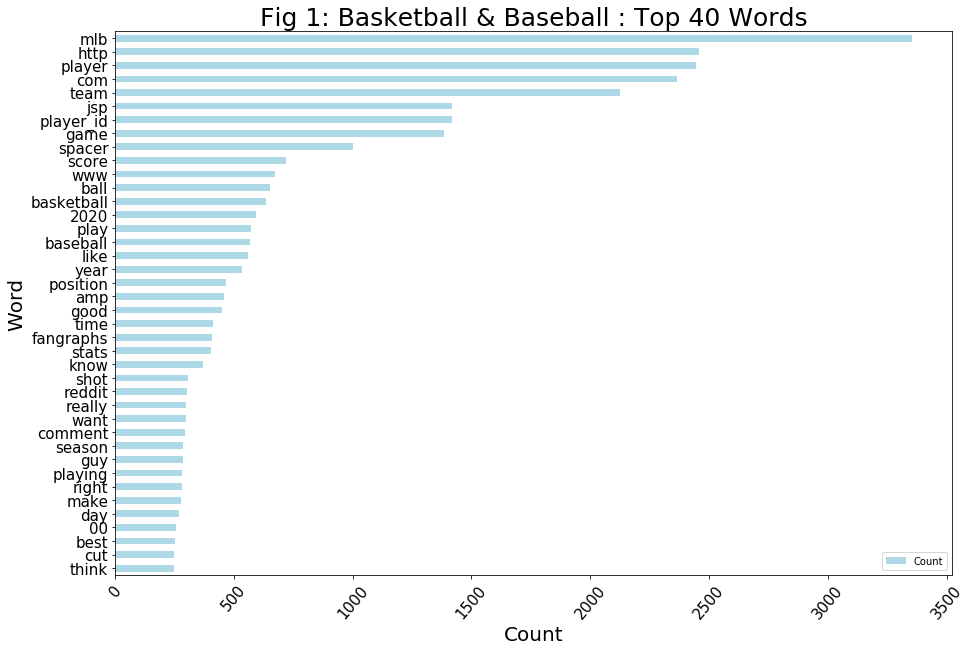

In [252]:

count.plot.barh(figsize=(15,10), color='lightblue')

plt.xlabel("Count", fontsize=20)
plt.ylabel("Word", fontsize=20)
plt.title('Fig 1: Basketball & Baseball : Top 40 Words',fontsize=25)

plt.tick_params(labelsize=15)
plt.xticks(rotation=50)

plt.show()


We note that the 5 most frequent words are: 'mlb', 'player' ,'http', 'team' and 'com'. Common high frequency words are 'player' and 'team', suggesting that both are equally important. Hence, marketing budgets could be balanced between individual celebrity sports endorsements as well as team features.VR headset content could also be geared towards featuring both of these.


### Using Histogram to Show High Frequency (Top 40) Words (Basketball)

In [253]:
basketball_words = df.loc[df['Basketball'] == 1]

In [254]:
basketball_cvec = cvec.fit_transform(basketball_words['selftext_title'])
basketball_cvec_df = pd.DataFrame(basketball_cvec.toarray(), columns=cvec.get_feature_names()) 

In [255]:
basketball_count = pd.DataFrame(basketball_cvec_df.sum(axis = 0))

In [256]:
basketball_count.columns = ['selftext_title']

In [257]:
basketball_count.sort_values(by = ['selftext_title'],ascending = True, inplace = True)

'basketball', 'game', 'ball', 'play', 'like' are top 5 words in Basketball Subreddit.


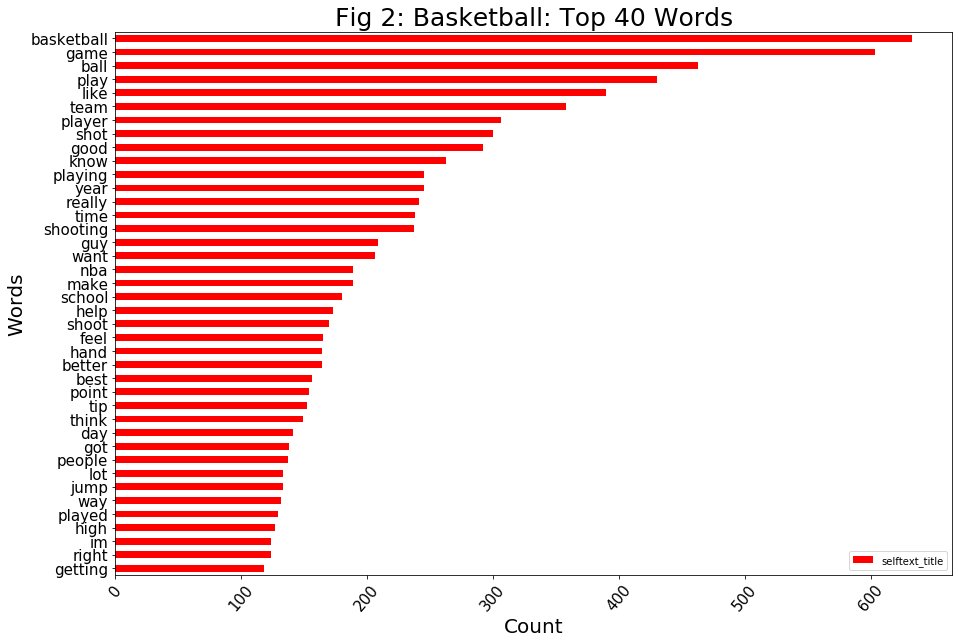

In [258]:

basketball_count.plot.barh(figsize=(15,10), color='red')
plt.xticks(rotation=50)
plt.xlabel("Count", fontsize=20)
plt.ylabel("Words", fontsize=20)
plt.title('Fig 2: Basketball: Top 40 Words', fontsize=25)
plt.tick_params(labelsize=15)
print("'basketball', 'game', 'ball', 'play', 'like' are top 5 words in Basketball Subreddit.")

**Basketball**

Basketball high frequency words such as "play","shot","good" suggests that basketball fans are more focused on the technical aspects of the game. Another high frequency word is 'school' which suggests that basketball fans are younger. One marketing strategy could be to feature ads during university or school related competitions or to come up with ads that would appeal to the basketball fanbase persona, which places importance on the technical skills of players. <br>



### Using Histogram to Show High Frequency (Top 40) Words (Basketball and Baseball)

In [259]:
baseball_words = df.loc[df['Basketball'] == 0]

In [260]:
baseball_cvec = cvec.fit_transform(baseball_words['selftext_title'])
baseball_cvec_df = pd.DataFrame(baseball_cvec.toarray(), columns=cvec.get_feature_names())

In [261]:
baseball_count = pd.DataFrame(baseball_cvec_df.sum(axis = 0))

In [262]:
baseball_count.columns = ['selftext_title']

In [263]:
baseball_count.sort_values(by = ['selftext_title'],ascending = True, inplace = True)

'mlb', 'http', 'com', 'player', 'Like' are top 5 words in Basketball Subreddit.


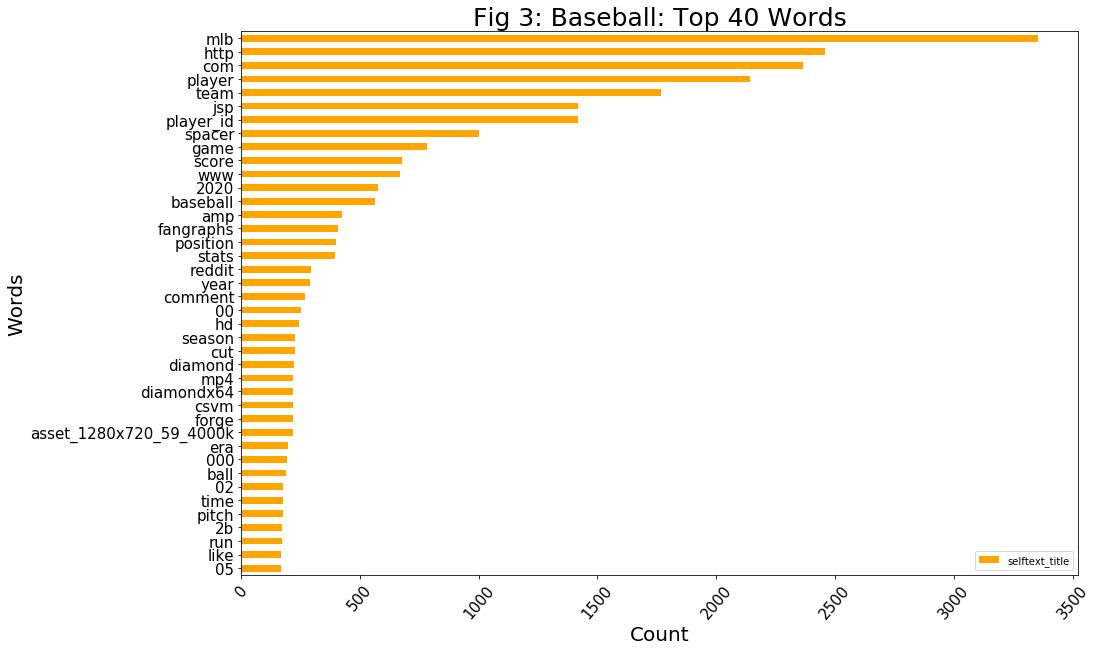

In [264]:
baseball_count.plot.barh(figsize=(15,10), color='orange')
plt.xticks(rotation=50)
plt.xlabel("Count", fontsize=20)
plt.ylabel("Words", fontsize=20)
plt.title('Fig 3: Baseball: Top 40 Words', fontsize=25)
plt.tick_params(labelsize=15)
print("'mlb', 'http', 'com', 'player', 'Like' are top 5 words in Basketball Subreddit.")


**Baseball**

Baseball has more internet related links (such as 'www', 'http', 'https'), which is less commonly found in the basketball reddit thread. This suggests that baseball fans are actively clicking on links and/ uploading videos. This informs the marketing strategy as more youtube ads or social media campaigns could be carried out to effectively target  these baseball fans. 

Ads could also be placed on selective websites. For instance, the 'fangraph' website is frequently mentioned under baseball. This is a website which provides statistics on baseball players as well as historical scores and predictions.  

Such strategies could effectively ensure higher estimated earnings per page view if the call-to-action is effective.

The word 'spacer' could refer to a brand of Nike basketball shoes. Alternatively 'spacer' is a sports term refering to a sports spacer. This lends insight into products that could be bundled alongside with our client's product.


In [265]:
basketball_count.columns = ['basketball_count']

In [266]:
baseball_count.columns = ['baseball_count']

In [267]:
combined_count = pd.concat([basketball_count, baseball_count], axis=1, sort=False)

### Showing Combined Counts for Basketball and Baseball

In [268]:
combined_count

,basketball_count,baseball_count
getting,118.0,NaN
right,124.0,NaN
im,124.0,NaN
high,127.0,NaN
played,129.0,NaN
...,...,...
player_id,NaN,1416.0
jsp,NaN,1417.0
com,NaN,2364.0
http,NaN,2456.0


'mlb', 'http', 'com', 'player', 'Like' are top 5 words in Basketball Subreddit.


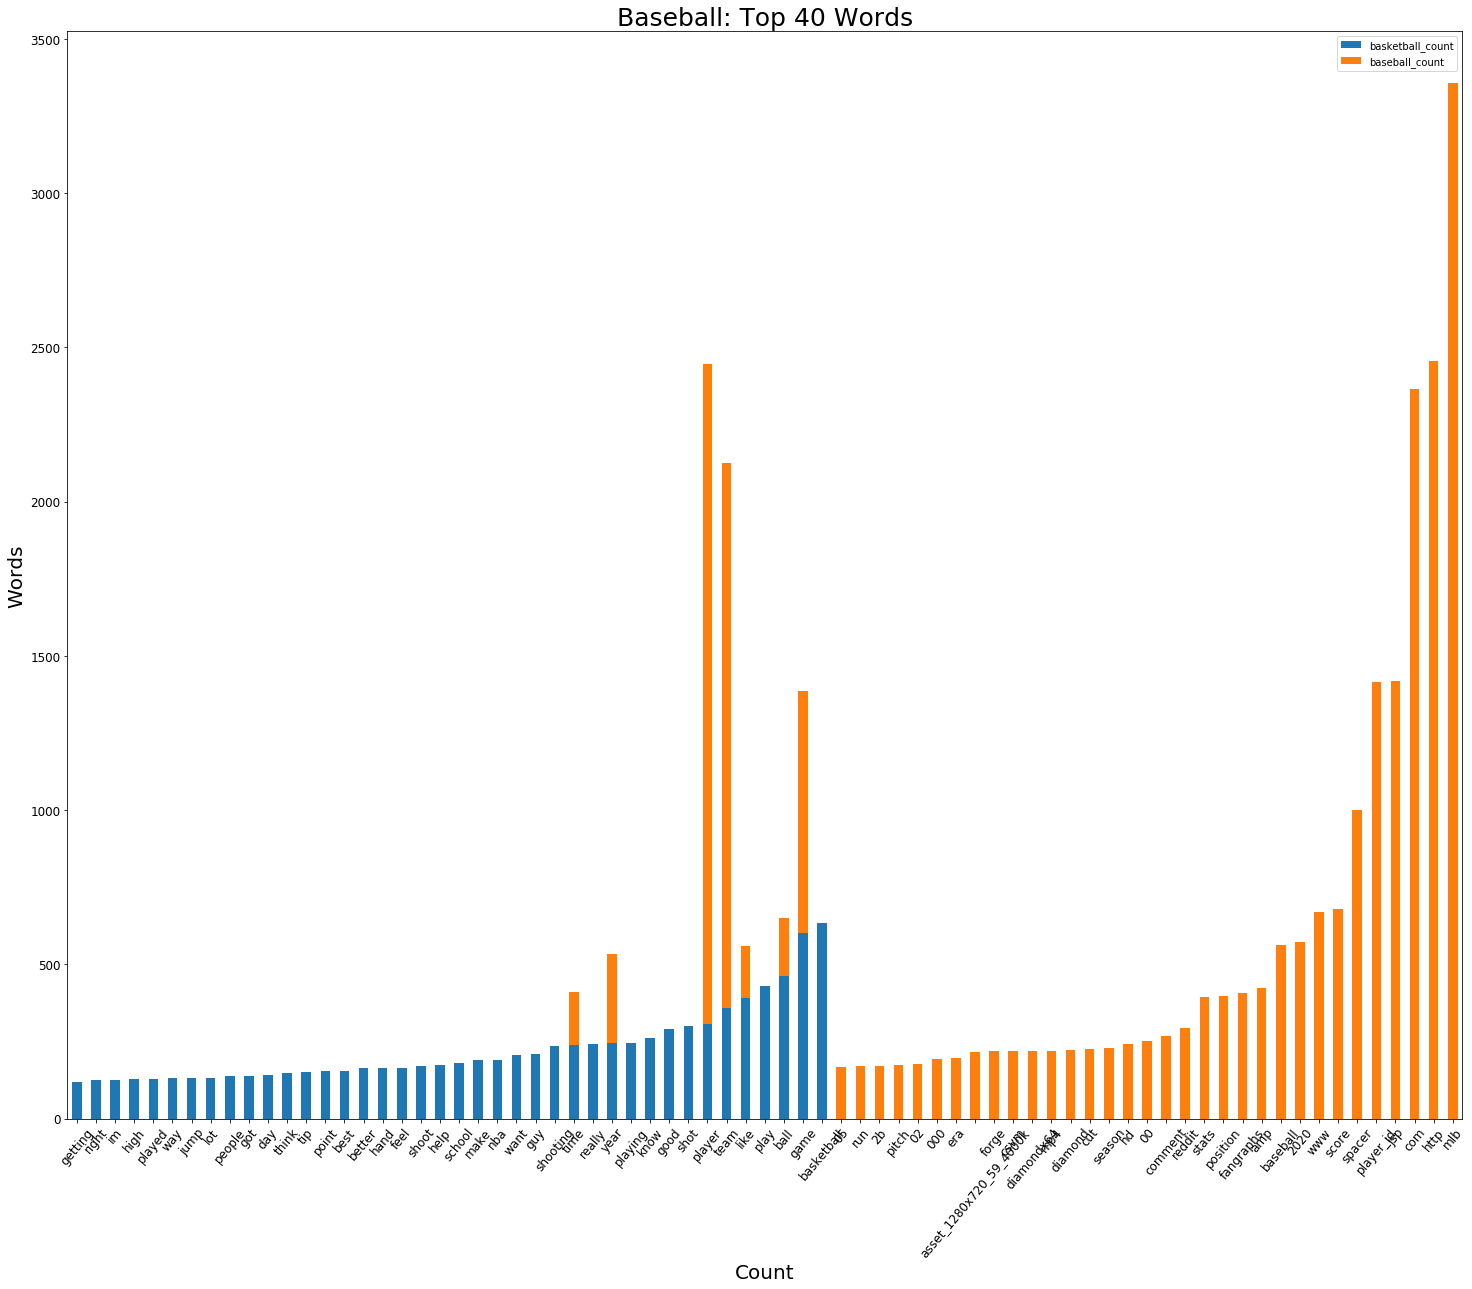

In [269]:
combined_count.plot.bar(stacked=True, figsize=(25,20))
plt.xticks(rotation=50)
plt.xlabel("Count", fontsize=20)
plt.ylabel("Words", fontsize=20)
plt.title('Baseball: Top 40 Words', fontsize=25)
plt.tick_params(labelsize=12)
print("'mlb', 'http', 'com', 'player', 'Like' are top 5 words in Basketball Subreddit.")

We note that there is a very  stark distinct difference in the high frequency words mentioned in basketball versus baseball reddit posts. This provides a good basis for our classification model.

For example, words like 'http','com' are less found in baseball. This informs us that marketing strategies is not a one-size fits all.


Baseball seems to be more popular than baseball on Reddit, given the frequency of major league baseball '(MLB)' rather than basketball is mentioned frequently. Alternatively this could be due to a larger member set (1.1m vs 51k members).

Given similar frequencies in the words 'team' and 'individual players', we can infer that both are equally important to fans.

We also infer interest in personal details surrounding baseball players due to the frequency of the website 'fangraphs' , which provides statistics for every player in Major League Baseball history,as well as scores and projections, appears to be a fairly popular website. The word 'diamond' is likely referring to the apparel organization that specializes in sports apparel in baseball. Both of these could provide opportunities for marketing tie-ups and spinoffs.



# **Naive Bayes Model**

## Instantiating the Naive Bayes Model (MultiNomial with CVEC and TVEC)

We will be using TFIDF(frequency–inverse document frequency) as a numerical statistic  to reflect how important a word is to a reddit post in our corpus. 

In [270]:
nb = MultinomialNB()

**Fitting the Model**

In [271]:
model_cvec=nb.fit(X_train_cvec, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [1859, 1394]

In [202]:
model_tvec=nb.fit(X_train_tvec, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [1859, 1394]

**Generating Predictions**

In [67]:
predictions_cvec=model_cvec.predict(X_test_cvec)

In [68]:
predictions_tvec=model_tvec.predict(X_test_tvec)

**Scoring the Model on Training Set**

In [69]:
cvec_train_nb_score=model_cvec.score(X_train_cvec,y_train)
tvec_train_nb_score=model_tvec.score(X_train_tvec,y_train)

print("The CountVectorizer/Naive Bayes train score is : {}".format(cvec_train_nb_score))
print("The TfidfVectorizer/Naive Bayes train score is : {}".format(tvec_train_nb_score))

The CountVectorizer/Naive Bayes train score is : 0.7295552367288379
The TfidfVectorizer/Naive Bayes train score is : 0.7281205164992827


**Scoring the Model on Test Set**

In [70]:
cvec_test_nb_score=model_cvec.score(X_test_cvec,y_test)
tvec_test_nb_score=model_tvec.score(X_test_tvec,y_test)

print("The CountVectorizer/Naive Bayes test score is : {}".format(cvec_test_nb_score))
print("The TfidfVectorizer/Naive Bayes test score is : {}".format(tvec_test_nb_score))

The CountVectorizer/Naive Bayes test score is : 0.7354838709677419
The TfidfVectorizer/Naive Bayes test score is : 0.7354838709677419


**Evaluation:** 

The train/test split shows a roughly similar score, indicating that the Naive Bayes CVEC model is generalised well enough to predict accurate enough results.

The test score is also slightly better than the train score. This suggests that there is no overfitting and that our model is effective, although there could still be room for improvement.


The Multinomial Naive Bayes model works by counting how often a certain event occurs in the dataset. As the columns of X are all integer counts, MultinomialNB is the best choice.

In [71]:
# pipe=Pipeline([
#     ("cvec", CountVectorizer(stop_words='english')),
#     ("nb", MultinomialNB())
# ])

In [72]:
# pipe_params={
#     'cvec__max_features':[80,150,200],
#     'cvec__min_df':[2,3],
#     'cvec__max_df':[0.2,.25,.3],
   
# }

# gs=GridSearchCV(pipe, param_grid=pipe_params,cv=5,n_jobs=-1)
# gs.fit(X_train, y_train)
# print(gs.best_score_)
# gs.best_params_



**Generating a Confusion Matrix (Naive Bayes CVEC)**

In [73]:
predictions_cvec.shape

(465,)

In [74]:
cm=confusion_matrix(y_test, predictions_cvec)

In [75]:
tn,fp,fn,tp=confusion_matrix(y_test, predictions_cvec).ravel()

In [76]:
print("True Negatives:{}".format(tn))
print("False Positives:{}".format(fp))
print("False Negatives:{}".format(fn))
print("True Positives:{}".format(tp))

True Negatives:121
False Positives:110
False Negatives:13
True Positives:221


In [77]:
accuracy = (tp + tn)/ (tp + tn + fp + fn)
sensitivity = (tp)/ (tp + fn)
specificity = (tn)/ (tn + fp)
precision = (tp) / (tp + fp)

In [78]:
print("Accuracy:{}".format(accuracy))
print("Sensitivity:{}".format(sensitivity))
print("Specificity:{}".format(specificity))
print("Precision:{}".format(precision))

Accuracy:0.7354838709677419
Sensitivity:0.9444444444444444
Specificity:0.5238095238095238
Precision:0.6676737160120846


In [79]:
cm_df=pd.DataFrame(cm, columns=['predict basketball','predict baseball'], index=['actual basketbal','actual malignant'])

In [80]:
cm_df

,predict basketball,predict baseball
actual basketbal,121,110
actual malignant,13,221


**Accuracy score of 0.8215 is fairly high and indicates that 0.82 of the the predictions are accurately classified.**

We are neutral towards optimizing for sensitivity or specificity, between basketball and baseball. 

However, in the case of a company with a smaller marketing budget, specificity could be an important factor of consideration as the opportunity cost of spending on an ineffective marketing campaign could be quite high, as there could be more pressing competing uses of limited funds elsewhere.



In [81]:
pred_proba = [i[1] for i in nb.predict_proba(X_test_cvec)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
195,1,9.969136e-01
291,1,6.705417e-01
961,0,1.782285e-01
136,1,6.126454e-01
1553,0,5.021521e-01
...,...,...
786,1,5.021521e-01
769,1,5.757174e-01
835,1,9.440388e-01
1548,0,1.089237e-01


In [82]:
roc_auc_score(pred_df['true_values'],pred_df['pred_probs'])

0.9236781736781737


By generating the ROC curve model, we can visualize our tradeoff between sensitivity and specificity

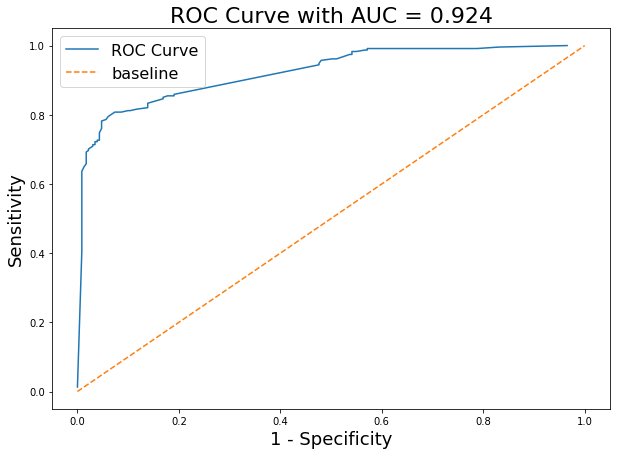

In [83]:
plt.figure(figsize = (10,7))

    # Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

    # Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


    # Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

    # Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
plt.legend(fontsize=16); 

In [84]:
Naive Bayes GridSearch with TVEC

We will run a pipeline to convert the raw data to matrix of TF-IDF features and then run the MultinomialNB classifier.

SyntaxError: invalid syntax (<ipython-input-84-9c9232439120>, line 1)

In [ ]:
# pipe=Pipeline([
#     ("tvec", TfidfVectorizer(stop_words='english')),
#     ("nb", MultinomialNB())
# ])

In [ ]:
# #Setting up parameters.
# pipe_params={
#     'tvec__max_features':[80,150,200],
#     'tvec__min_df':[2,3],
#     'tvec__max_df':[.2,.25,.3]
# }

# gs=GridSearchCV(pipe, param_grid=pipe_params,cv=5,n_jobs=-1)
# gs.fit(X_train, y_train)
# print(gs.best_score_)
# gs.best_params_


**Generating a Confusion Matrix (Naive Bayes TVEC)**

In [ ]:
y_test.values.shape

In [ ]:
predictions_tvec.shape

In [ ]:
confusion_matrix(y_test, predictions_tvec)

In [ ]:
tn,fp,fn,tp=confusion_matrix(y_test, predictions_tvec).ravel()

In [85]:
print("True Negatives:{}".format(tn))
print("False Positives:{}".format(fp))
print("False Negatives:{}".format(fn))
print("True Positives:{}".format(tp))

True Negatives:121
False Positives:110
False Negatives:13
True Positives:221


In [86]:
accuracy = (tp + tn)/ (tp + tn + fp + fn)
sensitivity = (tp)/ (tp + fn)
specificity = (tn)/ (tn + fp)
precision = (tp) / (tp + fp)

In [87]:
print("Accuracy:{}".format(accuracy))
print("Sensitivity:{}".format(sensitivity))
print("Specificity:{}".format(specificity))
print("Precision:{}".format(precision))

Accuracy:0.7354838709677419
Sensitivity:0.9444444444444444
Specificity:0.5238095238095238
Precision:0.6676737160120846


In [87]:
pred_proba = [i[1] for i in nb.predict_proba(X_test_tvec)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
195,1,0.978926
291,1,0.670542
961,0,0.178229
136,1,0.558118
1553,0,0.502152
...,...,...
786,1,0.502152
769,1,0.567735
835,1,0.619418
1548,0,0.169634


In [88]:
roc_auc_score(pred_df['true_values'],pred_df['pred_probs'])

0.9232896732896734

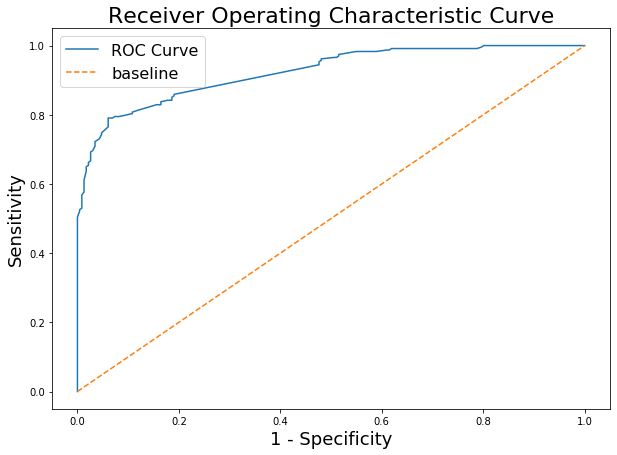

In [89]:
plt.figure(figsize = (10,7))

    # Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

    # Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


    # Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
tpr_values, # True Positive Rate on Y-axis
label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
np.linspace(0, 1, 200),
label='baseline',
linestyle='--')

    # Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
plt.legend(fontsize=16);
    
   

# Logistic Regression

In [90]:
lr=LogisticRegression()

In [91]:
model_cvec= lr.fit(X_train_cvec, y_train)
model_tvec= lr.fit(X_train_tvec, y_train)

In [92]:
prediction_cvec2 = model_cvec.predict(X_test_cvec)
predictions_tvec2 = model_tvec.predict(X_test_tvec)

In [93]:
cvec_train_lr_score=model_cvec.score(X_train_cvec, y_train)
tvec_train_lr_score=model_tvec.score(X_train_tvec, y_train)


print("The CountVectorizer/LogisticRegression train score is:{}".format(cvec_train_lr_score))
print("The TfidfVectorizer/LogisticRegression train score is:{}".format(tvec_train_lr_score))
      

The CountVectorizer/LogisticRegression train score is:0.8321377331420373
The TfidfVectorizer/LogisticRegression train score is:0.836441893830703


**Baseline Accuracy**

In [94]:
print(np.mean(y_test))

0.5032258064516129


**Logistic Regression GridSearch with CVEC**

We will be applying additional Lasso and Ridge penalties as regularization-relevant hyperprameters for our Logistic Regression model.

In [95]:
# pipe=Pipeline([
#     ("cvec", CountVectorizer(stop_words='english')),
#     ("lr", LogisticRegression())
# ])

In [96]:
# #Setting up parameters.
# pipe_params={
   
#     'cvec__max_features':[80,50,200],
#     'cvec__min_df':[2,3],
#     'cvec__max_df':[.2,.25,.3]
# }

# gs=GridSearchCV(pipe, param_grid=pipe_params,cv=5,n_jobs=-1)
# gs.fit(X_train, y_train)
# print(gs.best_score_)
# gs.best_params_


### Confusion Matrix (Logistic Regression CVEC)

In [97]:
confusion_matrix(y_test, prediction_cvec2)

array([[184,  47],
       [ 36, 198]])

In [98]:
print("True Negatives:{}".format(tn))
print("False Positives:{}".format(fp))
print("False Negatives:{}".format(fn))
print("True Positives:{}".format(tp))

True Negatives:121
False Positives:110
False Negatives:13
True Positives:221


In [99]:
accuracy = (tp + tn)/ (tp + tn + fp + fn)
sensitivity = (tp)/ (tp + fn)
specificity = (tn)/ (tn + fp)
precision = (tp) / (tp + fp)

In [100]:
print("Accuracy:{}".format(accuracy))
print("Sensitivity:{}".format(sensitivity))
print("Specificity:{}".format(specificity))
print("Precision:{}".format(precision))

Accuracy:0.7354838709677419
Sensitivity:0.9444444444444444
Specificity:0.5238095238095238
Precision:0.6676737160120846


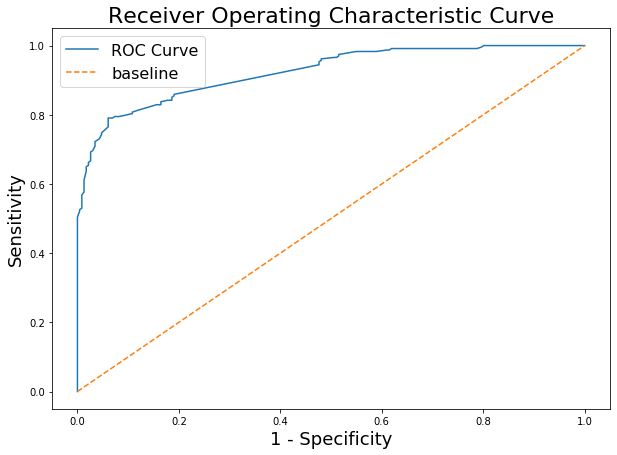

In [101]:
plt.figure(figsize = (10,7))

    # Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

    # Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


    # Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
tpr_values, # True Positive Rate on Y-axis
label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
np.linspace(0, 1, 200),
label='baseline',
linestyle='--')

    # Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
plt.legend(fontsize=16); 

In [102]:
roc_auc_score(pred_df['true_values'],pred_df['pred_probs'])

0.9232896732896734

**Logistic Regression GridSearch with TVEC**

In [103]:
pipe=Pipeline([
    ("tvec", TfidfVectorizer(stop_words='english')),
    ("lr", LogisticRegression())
])

In [105]:
#Setting up parameters.
pipe_params={
    'tvec__max_features':[80,50,200],
    'tvec__min_df':[2,3],
    'tvec__max_df':[.2,.25,.3],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1, 5, 10],
    'lr__max_iter': [20, 50, 100]

}

gs=GridSearchCV(pipe, param_grid=pipe_params,cv=5,n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda3/lib/python3.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/anaconda3/lib/python3.7/runpy.py in _run_code(code=<code object <module> at 0x1052744b0, file "/ana...3.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.7/site-packages/__pycache__/ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1052744b0, file "/ana...3.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/anaconda3/lib/python3.7/site-packages/__pycache__/ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    492         if self.poller is not None:
    493             self.poller.start()
    494         self.kernel.start()
    495         self.io_loop = ioloop.IOLoop.current()
    496         try:
--> 497             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    498         except KeyboardInterrupt:
    499             pass
    500 
    501 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
/anaconda3/lib/python3.7/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    518         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    519                                finalizer=self._asyncgen_finalizer_hook)
    520         try:
    521             events._set_running_loop(self)
    522             while True:
--> 523                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    524                 if self._stopping:
    525                     break
    526         finally:
    527             self._stopping = False

...........................................................................
/anaconda3/lib/python3.7/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1753                         logger.warning('Executing %s took %.3f seconds',
   1754                                        _format_handle(handle), dt)
   1755                 finally:
   1756                     self._current_handle = None
   1757             else:
-> 1758                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(15, 1)>>
   1759         handle = None  # Needed to break cycles when an exception occurs.
   1760 
   1761     def _set_coroutine_origin_tracking(self, enabled):
   1762         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
/anaconda3/lib/python3.7/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(15, 1)>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (15, 1)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=15, events=1)
    117             self.writers.remove(fd)
    118         del self.handlers[fd]
    119 
    120     def _handle_events(self, fd, events):
    121         fileobj, handler_func = self.handlers[fd]
--> 122         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    123 
    124     def start(self):
    125         try:
    126             old_loop = asyncio.get_event_loop()

...........................................................................
/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2020, 3, 16, 1, 20, 7, 961311, tzinfo=tzutc()), 'msg_id': 'ad62ac593fa14783a28ee5c55ad3cbb2', 'msg_type': 'execute_request', 'session': '7ffabebb330f447a86cd42de37bbd032', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ad62ac593fa14783a28ee5c55ad3cbb2', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'7ffabebb330f447a86cd42de37bbd032']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2020, 3, 16, 1, 20, 7, 961311, tzinfo=tzutc()), 'msg_id': 'ad62ac593fa14783a28ee5c55ad3cbb2', 'msg_type': 'execute_request', 'session': '7ffabebb330f447a86cd42de37bbd032', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ad62ac593fa14783a28ee5c55ad3cbb2', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'7ffabebb330f447a86cd42de37bbd032'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2020, 3, 16, 1, 20, 7, 961311, tzinfo=tzutc()), 'msg_id': 'ad62ac593fa14783a28ee5c55ad3cbb2', 'msg_type': 'execute_request', 'session': '7ffabebb330f447a86cd42de37bbd032', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'ad62ac593fa14783a28ee5c55ad3cbb2', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n", store_history=True, silent=False, shell_futures=True)
   2853         result : :class:`ExecutionResult`
   2854         """
   2855         result = None
   2856         try:
   2857             result = self._run_cell(
-> 2858                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n"
        store_history = True
        silent = False
        shell_futures = True
   2859         finally:
   2860             self.events.trigger('post_execute')
   2861             if not silent:
   2862                 self.events.trigger('post_run_cell', result)

...........................................................................
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n", store_history=True, silent=False, shell_futures=True)
   2881             runner = self.loop_runner
   2882         else:
   2883             runner = _pseudo_sync_runner
   2884 
   2885         try:
-> 2886             return runner(coro)
        runner = <function _pseudo_sync_runner>
        coro = <coroutine object InteractiveShell.run_cell_async>
   2887         except BaseException as e:
   2888             info = ExecutionInfo(raw_cell, store_history, silent, shell_futures)
   2889             result = ExecutionResult(info)
   2890             result.error_in_exec = e

...........................................................................
/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py in _pseudo_sync_runner(coro=<coroutine object InteractiveShell.run_cell_async>)
     63 
     64     Credit to Nathaniel Smith
     65 
     66     """
     67     try:
---> 68         coro.send(None)
        coro.send = <built-in method send of coroutine object>
     69     except StopIteration as exc:
     70         return exc.value
     71     else:
     72         # TODO: do not raise but return an execution result with the right info.

...........................................................................
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_cell_async(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="#Setting up parameters.\npipe_params={\n    'tvec_..., y_train)\nprint(gs.best_score_)\ngs.best_params_\n", store_history=True, silent=False, shell_futures=True)
   3058                 interactivity = "none" if silent else self.ast_node_interactivity
   3059                 if _run_async:
   3060                     interactivity = 'async'
   3061 
   3062                 has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
-> 3063                        interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   3064 
   3065                 self.last_execution_succeeded = not has_raised
   3066                 self.last_execution_result = result
   3067 

...........................................................................
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-105-ce6517d5d9de>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1a250e32e8, execution...rue silent=False shell_futures=True> result=None>)
   3249                     elif mode == 'single':
   3250                         mod = ast.Interactive([node])
   3251                     with compiler.extra_flags(getattr(ast, 'PyCF_ALLOW_TOP_LEVEL_AWAIT', 0x0) if self.autoawait else 0x0):
   3252                         code = compiler(mod, cell_name, mode)
   3253                         asy = compare(code)
-> 3254                     if (await self.run_code(code, result,  async_=asy)):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1a2622ef60, file "<ipython-input-105-ce6517d5d9de>", line 13>
        result = <ExecutionResult object at 1a250e32e8, execution...rue silent=False shell_futures=True> result=None>
        asy = False
   3255                         return True
   3256 
   3257             # Flush softspace
   3258             if softspace(sys.stdout, 0):

...........................................................................
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1a2622ef60, file "<ipython-input-105-ce6517d5d9de>", line 13>, result=<ExecutionResult object at 1a250e32e8, execution...rue silent=False shell_futures=True> result=None>, async_=False)
   3326                     code = compile('last_expr', 'fake', "single")
   3327                     exec(code, {'last_expr': last_expr})
   3328                 elif async_ :
   3329                     await eval(code_obj, self.user_global_ns, self.user_ns)
   3330                 else:
-> 3331                     exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1a2622ef60, file "<ipython-input-105-ce6517d5d9de>", line 13>
        self.user_global_ns = {'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'FPR': <function FPR>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'ImageColorGenerator': <class 'wordcloud.color_from_image.ImageColorGenerator'>, 'In': ['', "#All libraries used have been added here\nimport ...S, ImageColorGenerator\nnltk.download('stopwords')", "get_ipython().run_line_magic('pip', 'install -U tensorflow_estimator')", "basketball = pd.read_csv('./datasets/posts_baske...ll = pd.read_csv('./datasets/posts_baseball.csv')", '#creating a duplicate df that can be used later ...ll_1=basketball.copy()\nbaseball_1=baseball.copy()', '#checking our data\nbasketball_1.tail(100)\nbaseball_1.tail(100)', "#displaying all rows and columns to allow compre...', None)\n#pd.set_option('display.max_rows', None)", '#checking the number of posts before removal of ...eball: {}".format(len(basketball),len(baseball)))', '#checking the number of posts after removal of d...eball: {}".format(len(basketball),len(baseball)))', "#removal of unuseful data\n\nbasketball.drop(['Unn...aseball.drop(['Unnamed: 0'],axis=1, inplace=True)", '#removal of admin posts which are not reflective...tball.drop(basketball.index[[0,1]], inplace=True)', "basketball=basketball[['subreddit','selftext','t...seball=baseball[['subreddit','selftext','title']]", '#we replace NaN with an empty string to facilita...ce=True)\n    baseball[i].fillna(" ",inplace=True)', "#We join the'selftext' and 'title' of baseballba...ll[['selftext', 'title']].apply(' '.join, axis=1)", "#We join the'selftext' and 'title' of basketball...ll[['selftext', 'title']].apply(' '.join, axis=1)", "#We remove the individual 'selftext' and title c...eball=baseball.drop(['selftext','title'], axis=1)", 'def check_cols(basketball): # we create a functi... \n    return\npd.DataFrame(check_cols(basketball))', '#we check for NaNs in basketball\nbasketball.isnull().sum()', '#we check for NaNs in baseball\nbaseball.isnull().sum()', "pd.DataFrame(basketball.dtypes,columns=['data type'])", ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {1: True, 5:      Unnamed: 0 approved_at_utc subreddit  \
532...   NaN            NaN  

[100 rows x 107 columns], 16: Empty DataFrame
Columns: []
Index: [], 17: subreddit         0
selftext_title    0
dtype: int64, 18: subreddit         0
selftext_title    0
dtype: int64, 19:                data type
subreddit         object
selftext_title    object, 20:                data type
subreddit         object
selftext_title    object, 23:        subreddit                                ...  0  
1858           0  

[1859 rows x 3 columns], 28: 'basketball want thank ride past year chance comp...be somebody else thank sincerely thank basketball', 31:     subreddit                                   ...know throwing opposing team back rule hold tea..., ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
        self.user_ns = {'BeautifulSoup': <class 'bs4.BeautifulSoup'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'FPR': <function FPR>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'ImageColorGenerator': <class 'wordcloud.color_from_image.ImageColorGenerator'>, 'In': ['', "#All libraries used have been added here\nimport ...S, ImageColorGenerator\nnltk.download('stopwords')", "get_ipython().run_line_magic('pip', 'install -U tensorflow_estimator')", "basketball = pd.read_csv('./datasets/posts_baske...ll = pd.read_csv('./datasets/posts_baseball.csv')", '#creating a duplicate df that can be used later ...ll_1=basketball.copy()\nbaseball_1=baseball.copy()', '#checking our data\nbasketball_1.tail(100)\nbaseball_1.tail(100)', "#displaying all rows and columns to allow compre...', None)\n#pd.set_option('display.max_rows', None)", '#checking the number of posts before removal of ...eball: {}".format(len(basketball),len(baseball)))', '#checking the number of posts after removal of d...eball: {}".format(len(basketball),len(baseball)))', "#removal of unuseful data\n\nbasketball.drop(['Unn...aseball.drop(['Unnamed: 0'],axis=1, inplace=True)", '#removal of admin posts which are not reflective...tball.drop(basketball.index[[0,1]], inplace=True)', "basketball=basketball[['subreddit','selftext','t...seball=baseball[['subreddit','selftext','title']]", '#we replace NaN with an empty string to facilita...ce=True)\n    baseball[i].fillna(" ",inplace=True)', "#We join the'selftext' and 'title' of baseballba...ll[['selftext', 'title']].apply(' '.join, axis=1)", "#We join the'selftext' and 'title' of basketball...ll[['selftext', 'title']].apply(' '.join, axis=1)", "#We remove the individual 'selftext' and title c...eball=baseball.drop(['selftext','title'], axis=1)", 'def check_cols(basketball): # we create a functi... \n    return\npd.DataFrame(check_cols(basketball))', '#we check for NaNs in basketball\nbasketball.isnull().sum()', '#we check for NaNs in baseball\nbaseball.isnull().sum()', "pd.DataFrame(basketball.dtypes,columns=['data type'])", ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {1: True, 5:      Unnamed: 0 approved_at_utc subreddit  \
532...   NaN            NaN  

[100 rows x 107 columns], 16: Empty DataFrame
Columns: []
Index: [], 17: subreddit         0
selftext_title    0
dtype: int64, 18: subreddit         0
selftext_title    0
dtype: int64, 19:                data type
subreddit         object
selftext_title    object, 20:                data type
subreddit         object
selftext_title    object, 23:        subreddit                                ...  0  
1858           0  

[1859 rows x 3 columns], 28: 'basketball want thank ride past year chance comp...be somebody else thank sincerely thank basketball', 31:     subreddit                                   ...know throwing opposing team back rule hold tea..., ...}, 'Pipeline': <class 'sklearn.pipeline.Pipeline'>, ...}
   3332             finally:
   3333                 # Reset our crash handler in place
   3334                 sys.excepthook = old_excepthook
   3335         except SystemExit as e:

...........................................................................
/Users/joyceooi/Desktop/project_3/<ipython-input-105-ce6517d5d9de> in <module>()
      8     'lr__max_iter': [20, 50, 100]
      9 
     10 }
     11 
     12 gs=GridSearchCV(pipe, param_grid=pipe_params,cv=5,n_jobs=-1)
---> 13 gs.fit(X_train, y_train)
     14 print(gs.best_score_)
     15 gs.best_params_

...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...ain_score='warn',
       scoring=None, verbose=0), X=                                         selftex... dozier today signed ...

[1394 rows x 1 columns], y=173     1
1518    0
832     1
1270    0
944     ...   0
Name: Basketball, Length: 1394, dtype: int64, groups=None, **fit_params={})
    635                                   return_train_score=self.return_train_score,
    636                                   return_n_test_samples=True,
    637                                   return_times=True, return_parameters=False,
    638                                   error_score=self.error_score)
    639           for parameters, (train, test) in product(candidate_params,
--> 640                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X =                                          selftex... dozier today signed ...

[1394 rows x 1 columns]
        y = 173     1
1518    0
832     1
1270    0
944     ...   0
Name: Basketball, Length: 1394, dtype: int64
        groups = None
    641 
    642         # if one choose to see train score, "out" will contain train score info
    643         if self.return_train_score:
    644             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Mar 16 09:20:08 2020
PID: 5756                               Python 3.7.0: /anaconda3/bin/python
...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('tvec', Tfidf...0.0001,
          verbose=0, warm_start=False))]),                                          selftex... dozier today signed ...

[1394 rows x 1 columns], 173     1
1518    0
832     1
1270    0
944     ...   0
Name: Basketball, Length: 1394, dtype: int64, {'score': <function _passthrough_scorer>}, array([ 264,  265,  267, ..., 1391, 1392, 1393]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 283, 285,
       288, 289, 297, 298, 305, 307]), 0, {'lr__C': 1, 'lr__max_iter': 20, 'lr__penalty': 'l1', 'tvec__max_df': 0.2, 'tvec__max_features': 80, 'tvec__min_df': 2}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('tvec', Tfidf...0.0001,
          verbose=0, warm_start=False))]),                                          selftex... dozier today signed ...

[1394 rows x 1 columns], 173     1
1518    0
832     1
1270    0
944     ...   0
Name: Basketball, Length: 1394, dtype: int64, {'score': <function _passthrough_scorer>}, array([ 264,  265,  267, ..., 1391, 1392, 1393]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 283, 285,
       288, 289, 297, 298, 305, 307]), 0, {'lr__C': 1, 'lr__max_iter': 20, 'lr__penalty': 'l1', 'tvec__max_df': 0.2, 'tvec__max_features': 80, 'tvec__min_df': 2})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('tvec', Tfidf...0.0001,
          verbose=0, warm_start=False))]), X=                                         selftex... dozier today signed ...

[1394 rows x 1 columns], y=173     1
1518    0
832     1
1270    0
944     ...   0
Name: Basketball, Length: 1394, dtype: int64, scorer={'score': <function _passthrough_scorer>}, train=array([ 264,  265,  267, ..., 1391, 1392, 1393]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 283, 285,
       288, 289, 297, 298, 305, 307]), verbose=0, parameters={'lr__C': 1, 'lr__max_iter': 20, 'lr__penalty': 'l1', 'tvec__max_df': 0.2, 'tvec__max_features': 80, 'tvec__min_df': 2}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No....0001,
          verbose=0, warm_start=False))])>
        X_train =                                          selftex... dozier today signed ...

[1115 rows x 1 columns]
        y_train = 1145    0
1362    0
1655    0
1857    0
1241    ...   0
Name: Basketball, Length: 1115, dtype: int64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('tvec', Tfidf...0.0001,
          verbose=0, warm_start=False))]), X=                                         selftex... dozier today signed ...

[1115 rows x 1 columns], y=1145    0
1362    0
1655    0
1857    0
1241    ...   0
Name: Basketball, Length: 1115, dtype: int64, **fit_params={})
    243         Returns
    244         -------
    245         self : Pipeline
    246             This estimator
    247         """
--> 248         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N....0001,
          verbose=0, warm_start=False))])>
        X =                                          selftex... dozier today signed ...

[1115 rows x 1 columns]
        y = 1145    0
1362    0
1655    0
1857    0
1241    ...   0
Name: Basketball, Length: 1115, dtype: int64
    249         if self._final_estimator is not None:
    250             self._final_estimator.fit(Xt, y, **fit_params)
    251         return self
    252 

...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('tvec', Tfidf...0.0001,
          verbose=0, warm_start=False))]), X=                                         selftex... dozier today signed ...

[1115 rows x 1 columns], y=1145    0
1362    0
1655    0
1857    0
1241    ...   0
Name: Basketball, Length: 1115, dtype: int64, **fit_params={})
    208                 else:
    209                     cloned_transformer = clone(transformer)
    210                 # Fit or load from cache the current transfomer
    211                 Xt, fitted_transformer = fit_transform_one_cached(
    212                     cloned_transformer, None, Xt, y,
--> 213                     **fit_params_steps[name])
        fit_params_steps = {'lr': {}, 'tvec': {}}
        name = 'tvec'
    214                 # Replace the transformer of the step with the fitted
    215                 # transformer. This is necessary when loading the transformer
    216                 # from the cache.
    217                 self.steps[step_idx] = (name, fitted_transformer)

...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _fit_transform_one at 0x1a16f88378>), *args=(TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), None,                                          selftex... dozier today signed ...

[1115 rows x 1 columns], 1145    0
1362    0
1655    0
1857    0
1241    ...   0
Name: Basketball, Length: 1115, dtype: int64), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _fit_transform_one>
        args = (TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), None,                                          selftex... dozier today signed ...

[1115 rows x 1 columns], 1145    0
1362    0
1655    0
1857    0
1241    ...   0
Name: Basketball, Length: 1115, dtype: int64)
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), weight=None, X=                                         selftex... dozier today signed ...

[1115 rows x 1 columns], y=1145    0
1362    0
1655    0
1857    0
1241    ...   0
Name: Basketball, Length: 1115, dtype: int64, **fit_params={})
    576 
    577 
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
--> 581         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method TfidfVectorizer.fit_transform of T...zer=None, use_idf=True,
        vocabulary=None)>
        X =                                          selftex... dozier today signed ...

[1115 rows x 1 columns]
        y = 1145    0
1362    0
1655    0
1857    0
1241    ...   0
Name: Basketball, Length: 1115, dtype: int64
        fit_params = {}
    582     else:
    583         res = transformer.fit(X, y, **fit_params).transform(X)
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:

...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py in fit_transform(self=TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), raw_documents=                                         selftex... dozier today signed ...

[1115 rows x 1 columns], y=1145    0
1362    0
1655    0
1857    0
1241    ...   0
Name: Basketball, Length: 1115, dtype: int64)
   1376         Returns
   1377         -------
   1378         X : sparse matrix, [n_samples, n_features]
   1379             Tf-idf-weighted document-term matrix.
   1380         """
-> 1381         X = super(TfidfVectorizer, self).fit_transform(raw_documents)
        X = undefined
        self.fit_transform = <bound method TfidfVectorizer.fit_transform of T...zer=None, use_idf=True,
        vocabulary=None)>
        raw_documents =                                          selftex... dozier today signed ...

[1115 rows x 1 columns]
   1382         self._tfidf.fit(X)
   1383         # X is already a transformed view of raw_documents so
   1384         # we set copy to False
   1385         return self._tfidf.transform(X, copy=False)

...........................................................................
/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py in fit_transform(self=TfidfVectorizer(analyzer='word', binary=False, d...izer=None, use_idf=True,
        vocabulary=None), raw_documents=                                         selftex... dozier today signed ...

[1115 rows x 1 columns], y=None)
    881             min_doc_count = (min_df
    882                              if isinstance(min_df, numbers.Integral)
    883                              else min_df * n_doc)
    884             if max_doc_count < min_doc_count:
    885                 raise ValueError(
--> 886                     "max_df corresponds to < documents than min_df")
    887             X, self.stop_words_ = self._limit_features(X, vocabulary,
    888                                                        max_doc_count,
    889                                                        min_doc_count,
    890                                                        max_features)

ValueError: max_df corresponds to < documents than min_df
___________________________________________________________________________

**Model Evaluation, Conclusion and Recommendations**

We recommend.    which is the model with the highest accuracy.

We reviewed various models such as  multinomial Naive Bayes and logistic regression.

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification), while logistic regression is a technique that is well suited for examining the relationship between a categorical response variable and one or more categorical or continuous predictor variables.

Recommendations and Conclusions:

**Naive Bayes**

**Advantages:**
Our Naive Bayes has low computation cost and can efficiently work on a large dataset. This is useful in the long term, if we intend to expand our classification model to other overseas social platforms beyong Reddit.
Naive Bayes is a simple fast and accurate method for prediction and performs well in the case of text analytics problems. 

**Disadvantages:**
One drawback is the assumption of independence between different variables, wwhich may not hold true in reality.
In practice, it is almost impossible that model will get a set of predictors which are entirely independent.

**Logistic Regression**

**Advantages:**
Our Logistic Regression model is efficient and as such the most commonly used classification algorithm. It allows for interpretable co-efficients so that we can understand how X affects y. Logistic regression also does not suffer suffer from high variance due to the large number of simplifying assumptions placed on the model.

**Disadvantages:**

Logistic regression requires quite large sample sizes. This could limit our analysis, especially if sample size is small, resulting from the removal of duplicates or other irrelevant during webscraping.

Our focus will be on Sensitivity for the confusion matrix if the company is small. This is because the opportunity costs of untargeted ads could be quite large.


Our best model is  the Logistic Regression Model, using CountVectorizer and with added hyperparameters  scoring  0.92826398852223.

All models have consistently performed better than the baseline score (0.503) before and also after using Gridsearch to find the best parameters.

We note limitations to our model, such as the fact that only Reddit posts have been analyzed. This skews our findings towards a certain demographic that is active on Reddit but excludes other demongraphic types on other media platforms.


We recommend that our client focus on digital marketing for the basketball segment and for competition related marketing for basketball. This is because of the high frequency words mentioned. For basketball, the focus appears to be on sporting techniques or skills and in the case of  baseball, the focus seems to be on websites such as Fangraph and the uploading of urls or links. 

We also recognize potential business partnerships in these websites and on apparel organizations such as 'Diamond' sportswear.


